<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Triplet_Loss_Newts_ReID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import datasets

In [1]:

!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git
#!pip install kaggle

#from google.colab import files
#files.upload()
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp /content/Stage_Tritons/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! kaggle datasets download -d guillaumemagnette/datasetfinal/bf71bf5fd008dbdc0533720633d31a9dc98c7aea3bf59faa0eb4c14a428b9936


Cloning into 'Stage_Tritons'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3290 (delta 59), reused 18 (delta 7), pack-reused 3199
Receiving objects: 100% (3290/3290), 186.99 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Checking out files: 100% (6177/6177), done.
 95% 287M/303M [00:07<00:00, 41.0MB/s]
100% 303M/303M [00:07<00:00, 40.2MB/s]


In [2]:
!unzip -q /content/datasetfinal.zip

# Segmentation algorithms

## Segmentation of newts using a Mask R-CNN

### Import necessary modules

import the preaugmented dataset generated from the method preaugment

In [ ]:
""" the Mask RCNN has been implemented with Tensorflow 1.x
    Restart the runtime Tensorflow 2.x were imported.
"""

try:
  %tensorflow_version 1.x
except:
  pass

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
!pip install keras==2.2.5

!git clone https://github.com/matterport/Mask_RCNN.git

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Root directory of the project
#ROOT_DIR = os.getcwd()
#if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
   # ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
#sys.path.append(ROOT_DIR)

import mrcnn.utils
import mrcnn.visualize as visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import skimage
from skimage import measure
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import rotate, AffineTransform, swirl, resize
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import io, img_as_float, img_as_float64
from scipy import ndimage
from pathlib import Path

from random import random, uniform

import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow


import numba
from numba import jit



%matplotlib inline

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 3.3MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (566/566), done.


Using TensorFlow backend.


In [ ]:
import shutil
""" Define useful paths and download the pretrained weights of the Mask RCNN """
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")
source = '/content/pattern_annotated/pattern_annotated/' 
destination = '/content/Mask_RCNN/'
shutil.move(source, destination)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)


# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


... done downloading pretrained model!


In [ ]:
############################################################
#  Configurations
############################################################


class NewtsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "newt"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + newts

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [ ]:
############################################################
#  Dataset
############################################################

class NewtsDataset(utils.Dataset):

    def load_newts(self, dataset_dir, subset):
        """Load a subset of the newts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("newt_pattern", 1, "newt_pattern")

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        #/content/images_annotated/via_export_newts.json
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_newts_pattern.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newt_pattern",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a newt dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "newt_pattern":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "newt_pattern":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [ ]:
config = NewtsConfig()
NEWTS_DIR = os.path.join(ROOT_DIR, "pattern_annotated")

In [ ]:

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = NewtsDataset()
#dataset.load_newts(IMAGE_DIR, "train")
dataset.load_newts(NEWTS_DIR, "train")
# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 80
Class Count: 2
  0. BG                                                
  1. newt_pattern                                      


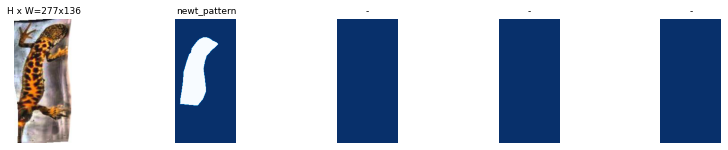

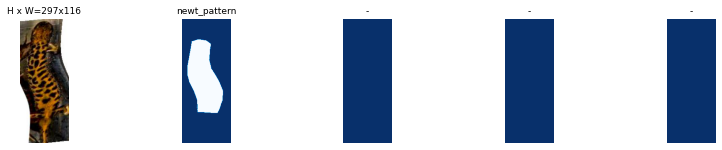

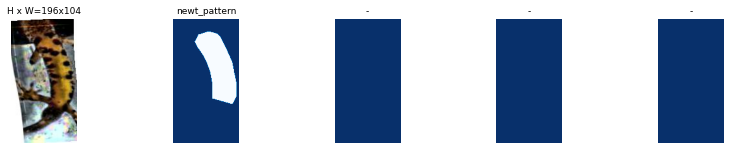

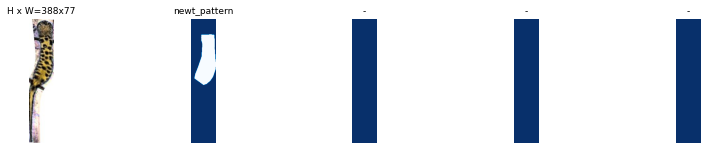

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  66 /content/Mask_RCNN/pattern_annotated/Bascha_P01_T04_K14_M_Adult_1138_20190607202201.jpg
image                    shape: (269, 134, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (269, 134, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   34.00000  max:  182.00000  int32


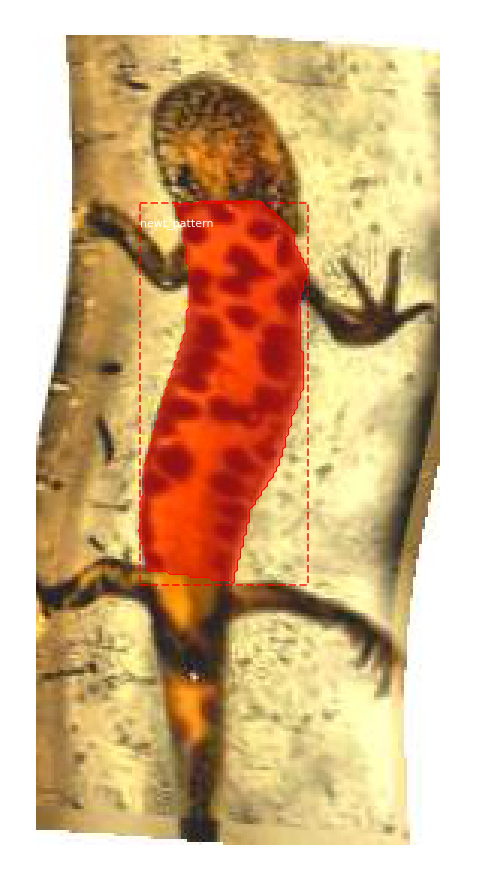

In [ ]:
#Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Train the mask R-CNN. I have already trained it and the weights are saved in the folder.

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = NewtsDataset()
    dataset_train.load_newts(NEWTS_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = NewtsDataset()
    dataset_val.load_newts(NEWTS_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    #model.metrics_tensors = []
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=60,
                layers='heads')

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
#weights_path = '/content/Mask_RCNN/logs/newt_pattern20200602T1046/mask_rcnn_newt_pattern_0040.h5'
#model.load_weights(weights_path, by_name=True)




In [ ]:
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/newt20200615T1345/mask_rcnn_newt_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 1/60
 52/100 [==============>...............] - ETA: 2:36 - loss: 13.0297 - rpn_class_loss: 1.7726 - rpn_bbox_loss: 7.5273 - mrcnn_class_loss: 0.2075 - mrcnn_bbox_loss: 2.9119 - mrcnn_mask_loss: 0.6104

Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    

KeyboardInterrupt: ignored

### Inference part. I load the weights resulting from the training phase.

I have to run the cell twice to correctly be in inference mode

In [ ]:
class InferenceConfig(NewtsConfig):
  """ Config to be used for the inferences """
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1


config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path = '/content/mask_rcnn_newt_pattern_0060.h5'
model.load_weights(weights_path, by_name=True)



methods used to show results of segmentation on images of the dataset pre-augmented

In [ ]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(img_path))
        # Read image
        image = skimage.io.imread(img_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
        plt.imshow(splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)



Running on /content/aug_database_for_seg/aug_database_for_seg/Bascha_P01_T06_K17_U_Juvenile_6664_20190628041159.jpg
Processing 1 images
image                    shape: (208, 54, 3)          min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to  splash_20200615T135157.png


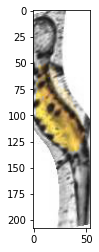

In [ ]:
img_path = '/content/aug_database_for_seg/aug_database_for_seg/Bascha_P01_T06_K17_U_Juvenile_6664_20190628041159.jpg'
detect_and_color_splash(model, image_path=img_path, video_path=None)

## Segmentation of newts using a UNet network

### Import necessary modules

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

%tensorflow_version 2.x
%matplotlib inline

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

from os import path                      # os level path manipulation
from glob import glob                    # Unix style pathname pattern expansion
import numpy as np                       # array goodnes
from matplotlib import pyplot as plt     # plotting library
import nibabel as nib                    # handlie NIFTI files
from tqdm import tqdm, trange            # progress bars
from tensorflow.keras.utils import get_file  # handy function to download data

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

import os
import sys
import json
import datetime
import numpy as np
import skimage.io
import skimage.draw

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

from skimage.transform import resize             # resize images
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.exposure import rescale_intensity   # used to normalize the image data
from sklearn.model_selection import train_test_split    # helper function to split the data
from skimage.morphology import area_closing, area_opening, binary_closing, binary_opening, black_tophat, closing, opening, skeletonize


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-mvrie2eh
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-mvrie2eh
  Created wheel for tensorflow-examples: filename=tensorflow_examples-40e3ac5b5c17ac75352b99747b8532272204365f_-cp36-none-any.whl size=131270 sha256=debe36bcec2995ab2ced20a3a8815e4b44de240bbb9f085d2f55f8f0f3033763
  Stored in directory: /tmp/pip-ephem-wheel-cache-m9g5tpag/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.6/dist-packages (3.1.0.dev202006170105)


In [2]:
def prepare_dataset(dataset_dir, subset, target_shape):
        """Load a subset of the newts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val

        then 

        Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        X, Y = [], []

        image_ids = []
        image_info = []
        # Background is always the first class
        class_info = [{"source": "", "id": 0, "name": "BG"}]
        source_class_ids = {}
        # Add classes. We have only one class to add.
        #self.add_class("newt_pattern", 1, "newt_pattern")
        class_info.append({"newt_pattern", 1, "newt_pattern"})

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        #/content/images_annotated/via_export_newts.json
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_newts_pattern.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            #print(image.shape)
            height, width = image.shape[:2]

            image_info.append(
                {"source":"newt_pattern",
                "image_id":a['filename'],  # use file name as a unique image id
                "path":image_path,
                "width":width, "height":height,
                "polygons":polygons})
            

            image = resize(image, target_shape, preserve_range=True)
            image = rescale_intensity(image, 'image', (0, 1.0))

            X.append(image)
            #image = np.expand_dims(image, -1)
       
        # If not a newt dataset image, delegate to parent class.
        #image_info = self.image_info[image_id]
        #if image_info["source"] != "newt_pattern":
        #    return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]

        for info in image_info:

          mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
          for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc] = i+1
            
          mask = mask[:,:,0]
          mask[mask == 1] = 255
          mask = resize(mask, (target_shape[0], target_shape[1], 1), preserve_range=True,)
          mask[mask > 0] = 1
         # print(np.max(mask))
          
          #print(np.max(mask[:,:,0]))
          #print(np.max(mask[:,:,1]))
          #print(np.max(mask[:,:,2]))

          #plt.imshow(mask[:,:,0])
          #plt.show()
          #plt.imshow(mask[:,:,1])
          #plt.show()
          #plt.imshow(mask[:,:,2])
          #plt.show()
         
         # ma_onehot = []
          #for cls in [0, 1]:
           # ma_onehot.append(mask == cls)
          #ma_onehot = np.stack(ma_onehot, axis=-1)
          #print(ma_onehot)
          Y.append(mask)
        #mask[mask == 0] = -1
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
        return X,Y

In [4]:
target_shape = (128, 128, 3)
X,Y = prepare_dataset('/content/pattern_annotated/pattern_annotated', 'train', target_shape)
#plt.imshow(X[0])
#print(np.min(X[0]))
#print(Y)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)


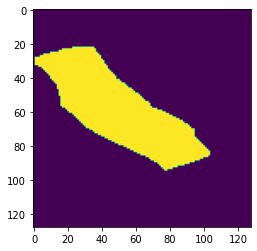

In [5]:
plt.imshow(np.squeeze(Y[0]))

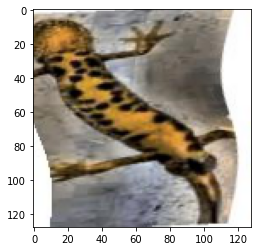

In [6]:
plt.imshow(X[0])

Let's take a look at an image example and it's correponding mask from the dataset.

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

### Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [8]:
OUTPUT_CHANNELS = 2

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [10]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [11]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1}. The network here is outputting two channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [12]:
tf.keras.backend.clear_session()
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

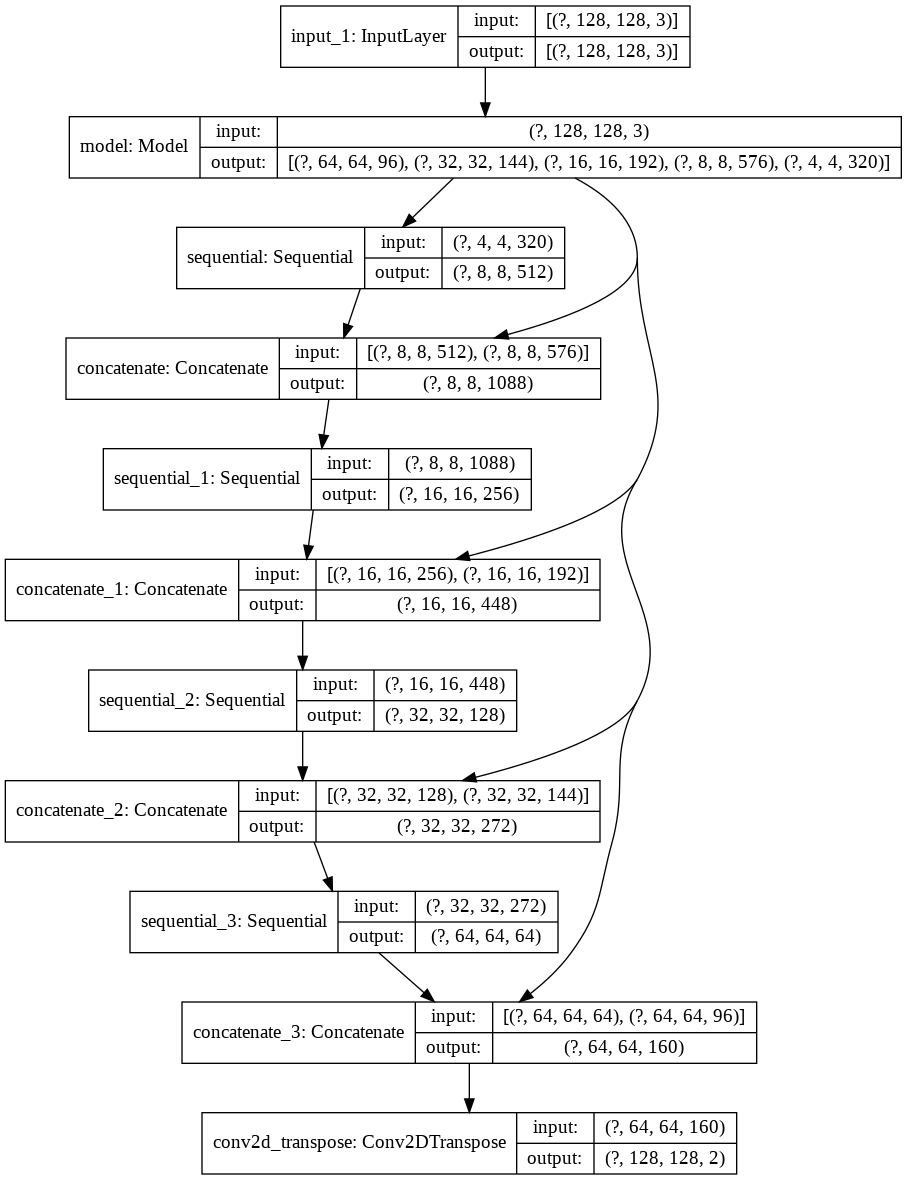

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  

  #pred_mask = area_closing(pred_mask, area_threshold=4, connectivity=1, parent=None, tree_traverser=None)tf.keras.preprocessing.image.img_to_array

  return pred_mask[0]

In [14]:
def show_predictions(X = X_val[0], Y = Y_val[0], num=1):
  
  if len(X.shape) > 3:
    for image, mask in zip(X,Y):
      pred_mask = model.predict(image[tf.newaxis, ...])
      display([image, mask, create_mask(pred_mask)])
  else:
    display([X, Y,
             create_mask(model.predict(X[tf.newaxis, ...]))])

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

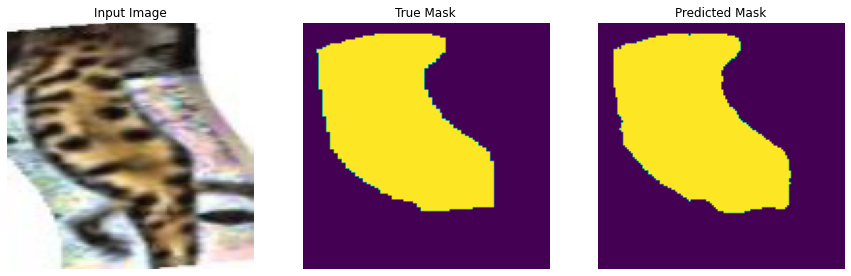


Sample Prediction after epoch 10

90/90 [==============================] - 1s 13ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [16]:
EPOCHS = 10
""" train only the upscaling layers first"""
model_history = model.fit(X, Y, epochs=EPOCHS,
                          validation_data=[X_val,Y_val],
                          callbacks=[DisplayCallback()],
                          batch_size=1)

""" fine-tune the model """
model.trainable = True


model_history = model.fit(X, Y, epochs=EPOCHS,
                          validation_data=[X_val,Y_val],
                          callbacks=[DisplayCallback()],
                          batch_size=1)

In [ ]:
model.summary()

### Show predictions on the dataset

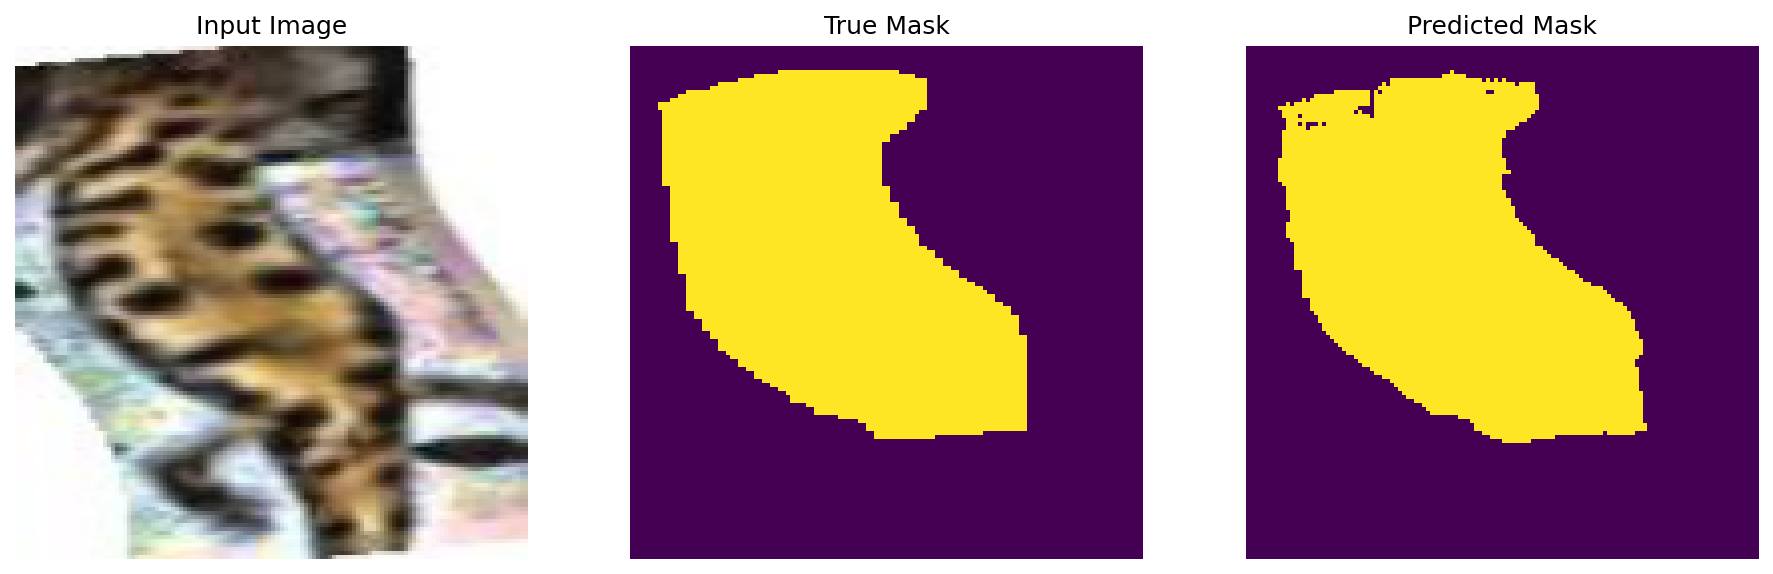

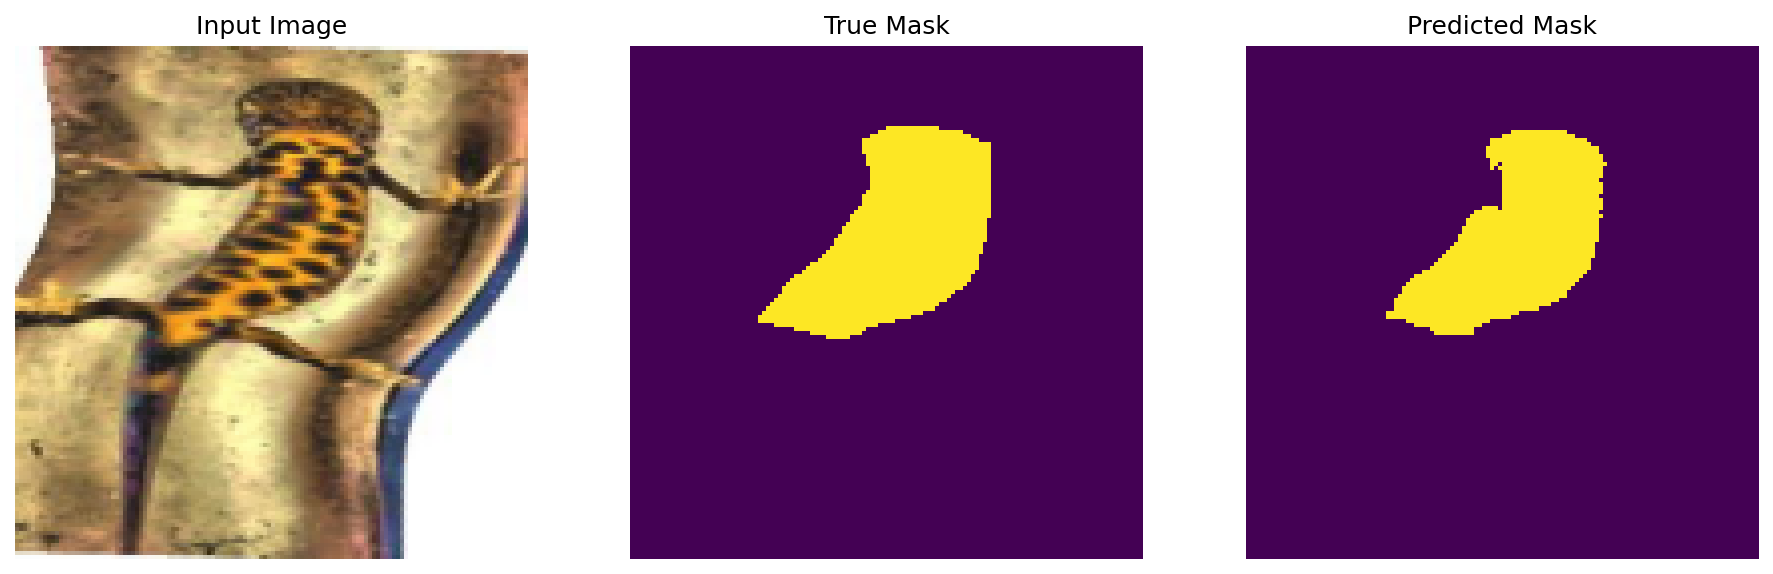

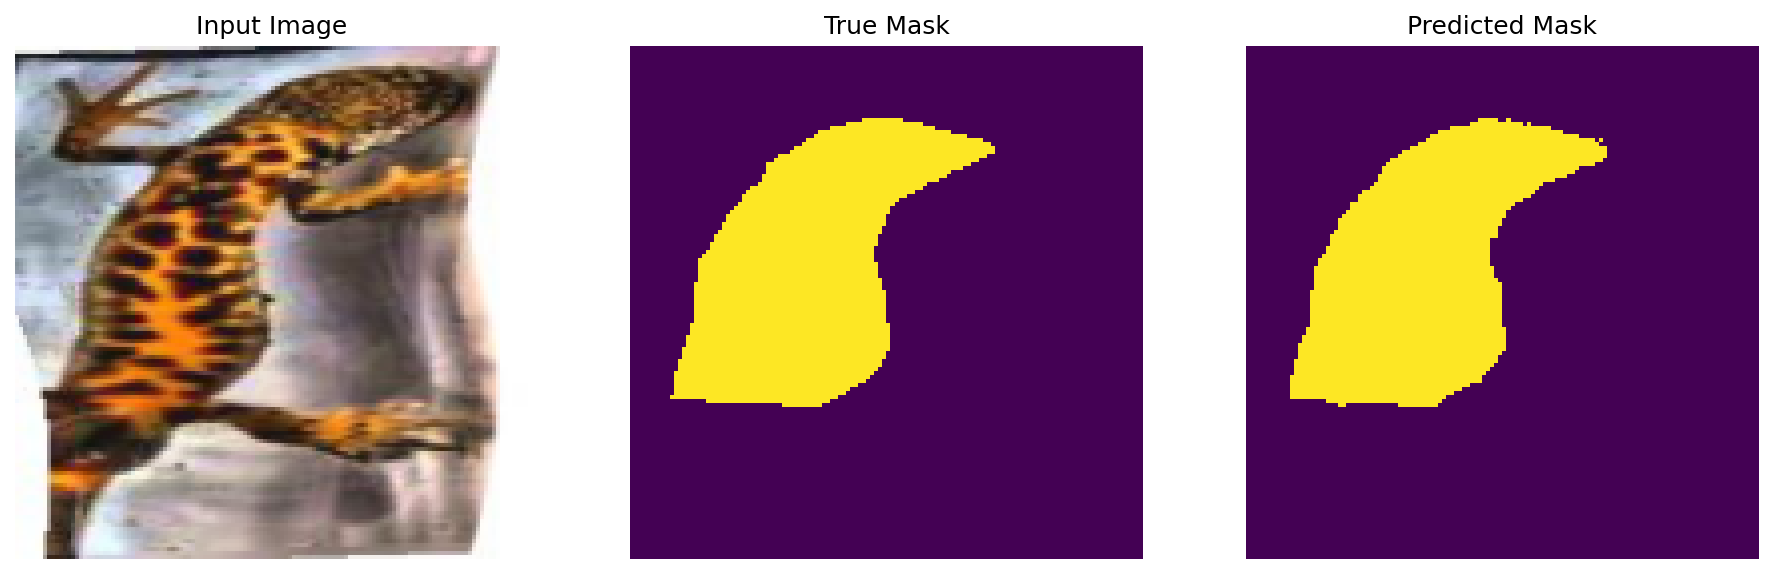

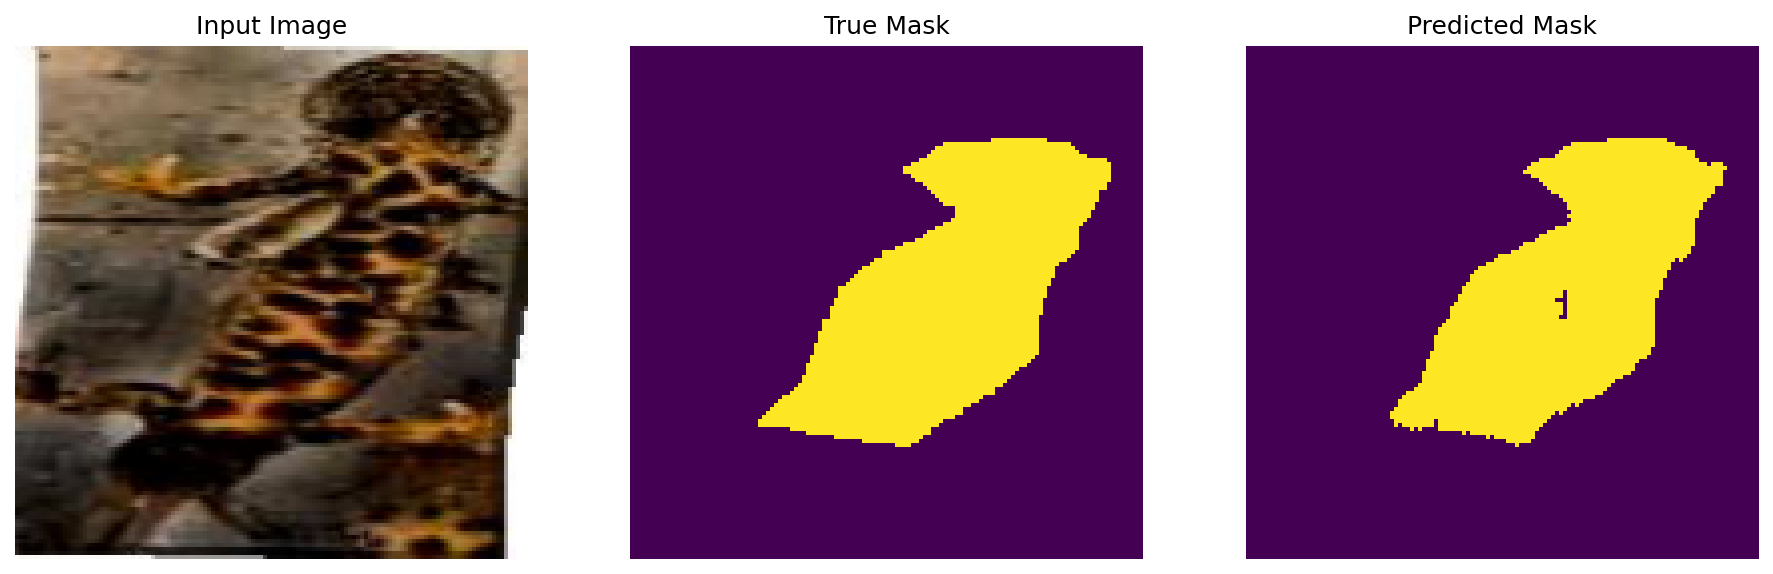

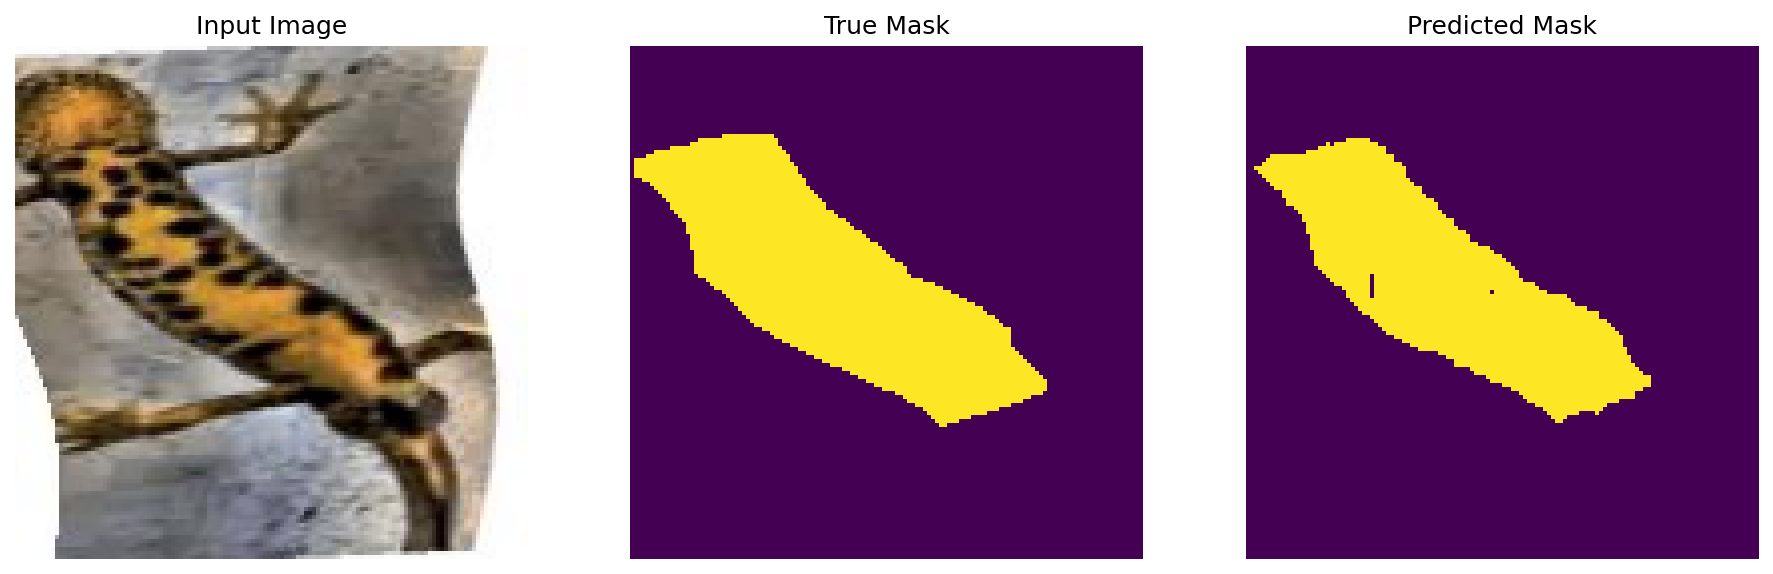

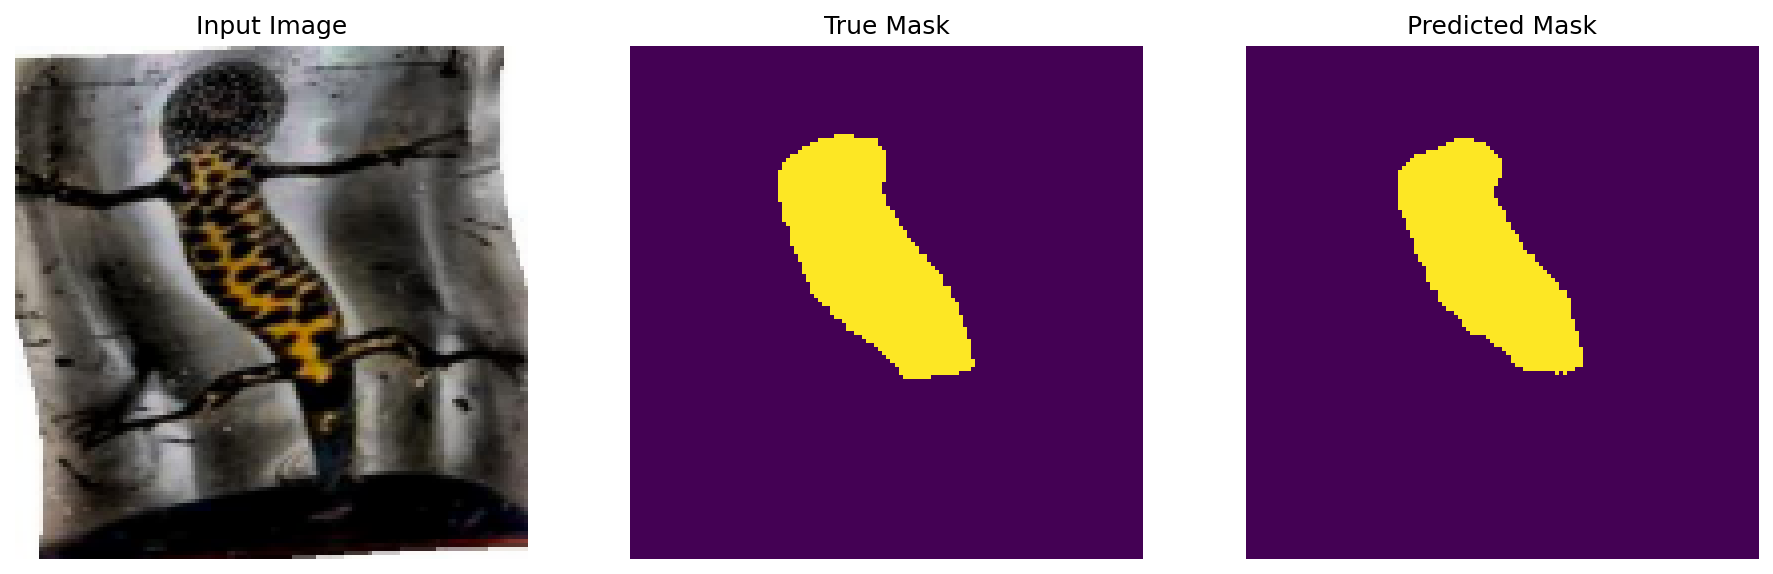

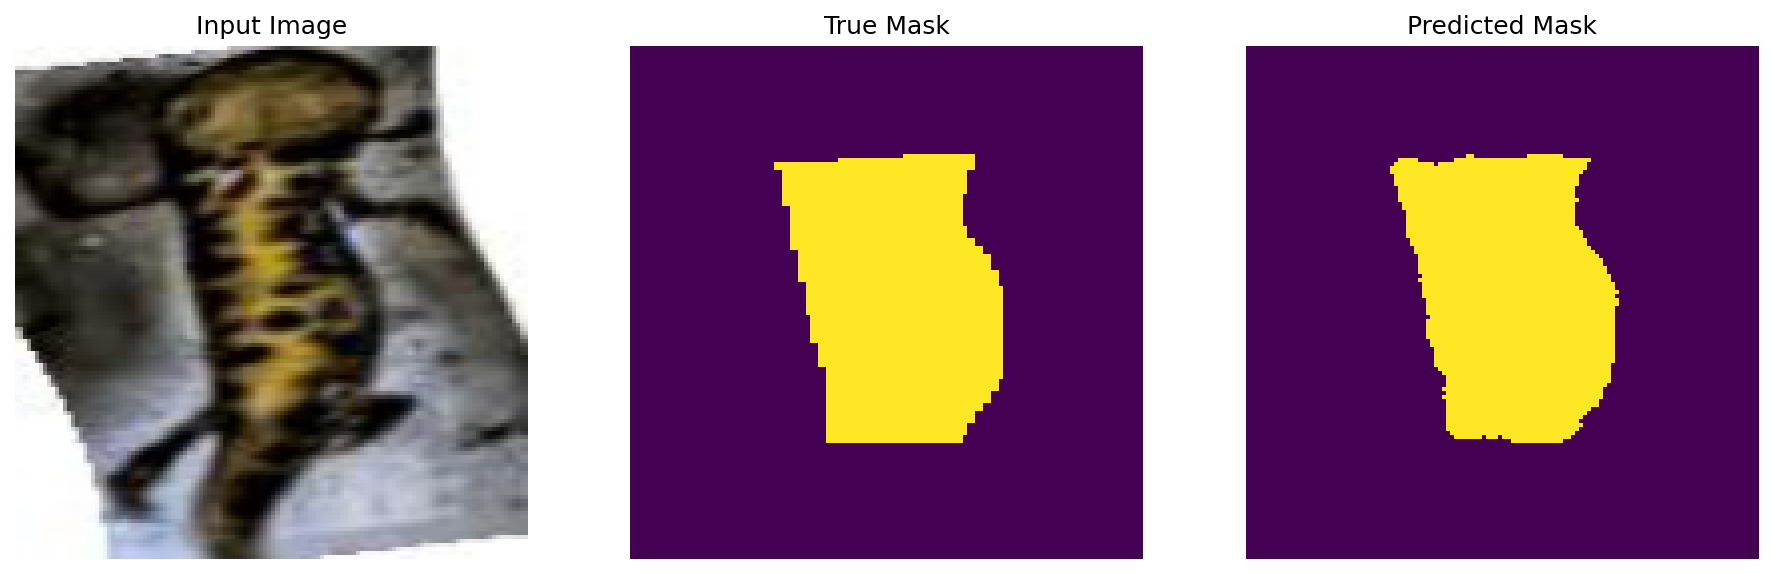

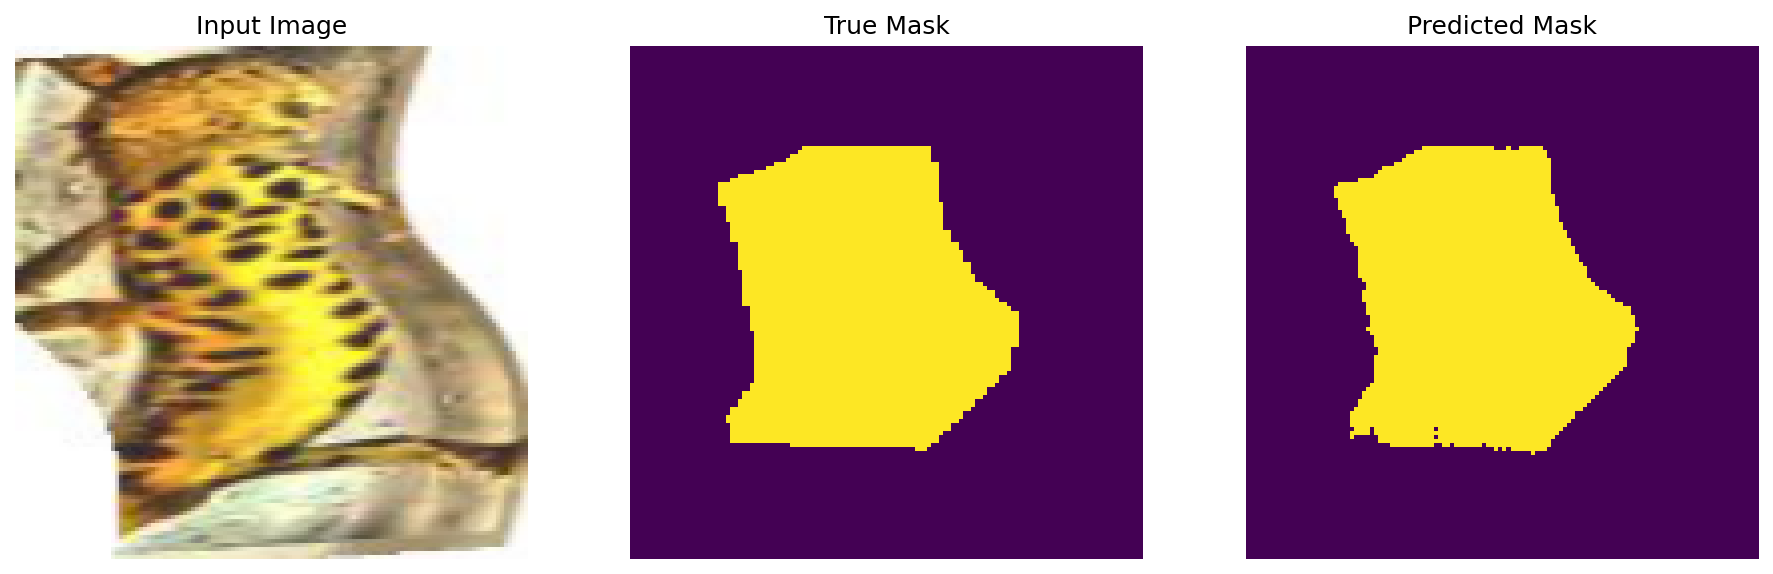

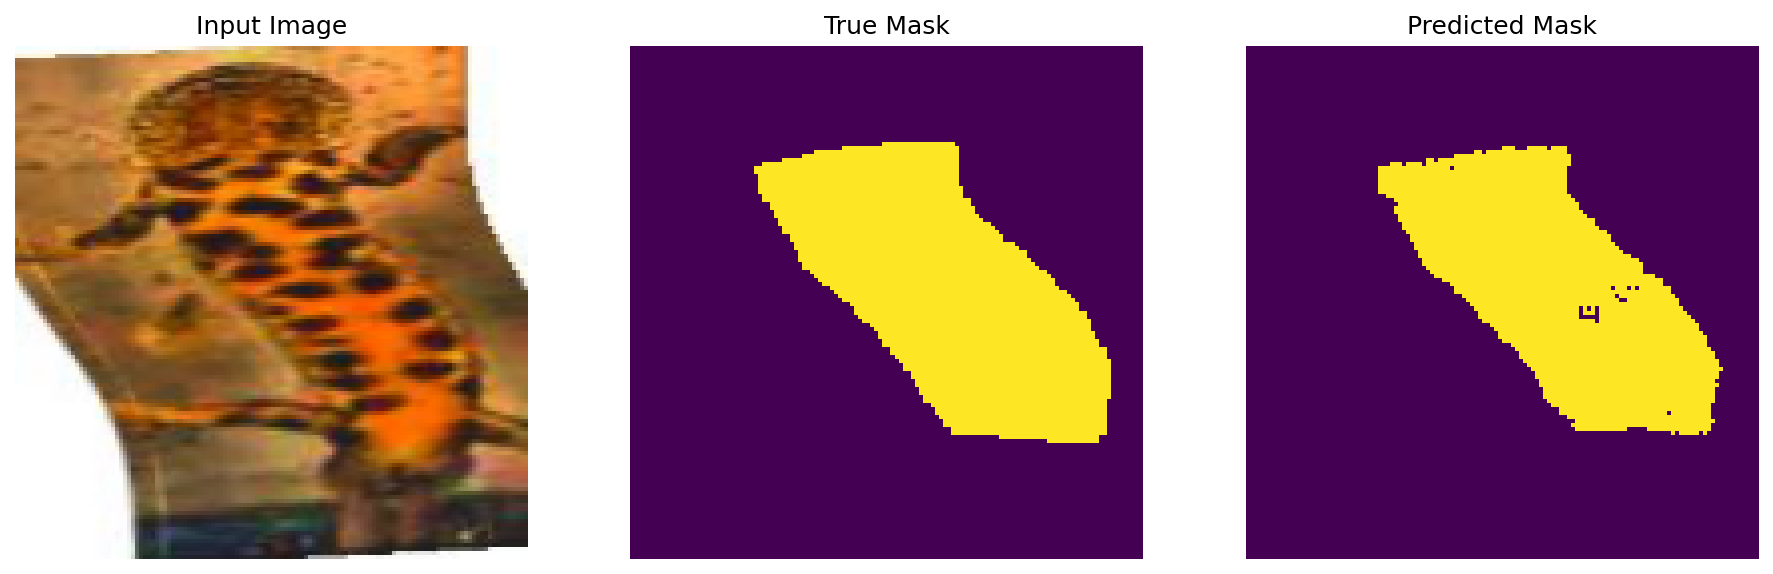

In [16]:
show_predictions(X_val, Y_val, 6)

In [17]:

img_path = '/content/aug_database_for_seg/aug_database_for_seg'

X_test = []
for img_name in os.listdir(img_path):
    
  imagePath = img_path + '/' + img_name

  if os.path.isfile(imagePath) and imagePath.endswith(".jpg"):

    image = plt.imread(imagePath)
    image = resize(image, target_shape, preserve_range=True)
    X_test.append(image)

X_test = np.stack(X_test, axis=0)
#print(X_test)

In [ ]:
from skimage.util import img_as_float
num = 500
k = 0
for image in X_test:
  if k < num:
    pred_mask = create_mask(model.predict(image[tf.newaxis, ...]/255))
    #pred_mask = img_as_float(pred_mask)
    #print(pred_mask)
    #print(np.max(pred_mask))
    #print(tf.keras.preprocessing.image.img_to_array(pred_mask).shape)
    #print(np.max(pred_mask[0]))
    
    pred_mask = tf.keras.preprocessing.image.img_to_array(pred_mask)
    #print(np.max(pred_mask))
   
    selem = skimage.morphology.disk(6)
    pred_mask = closing(np.squeeze(pred_mask*255), selem)
    pred_mask = opening(np.squeeze(pred_mask), selem)

    pred_mask = resize(pred_mask, (200,30, 1), preserve_range=True)
    skeleton = skeletonize(rescale_intensity(tf.keras.preprocessing.image.img_to_array(pred_mask),in_range=(-1,1)))
    #pred_mask = binary_closing(pred_mask[0], selem=skimage.morphology.disk(3))
    #pred_mask = black_tophat(pred_mask, selem=None, out=None)
    #pred_mask = area_closing(tf.keras.preprocessing.image.img_to_array(pred_mask), area_threshold=64, connectivity=1, parent=None, tree_traverser=None)
    #pred_mask = area_closing(np.squeeze(tf.keras.preprocessing.image.img_to_array(pred_mask)), area_threshold=128, connectivity=2, parent=None, tree_traverser=None)
    #pred_mask = area_opening(pred_mask, area_threshold=128,, connectivity=2, parent=None, tree_traverser=None)
    #tf.expand_dims(pred_mask, axis = -1)
    display([resize(image/255, (75,30, 3), preserve_range=True), resize(pred_mask, (75,30, 3), preserve_range=True), resize(skeleton, (75,30, 3), preserve_range=True)])

    k += 1



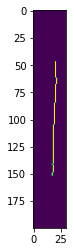

In [43]:
skeleton = skeletonize(rescale_intensity(tf.keras.preprocessing.image.img_to_array(pred_mask),in_range=(-1,1)))
plt.imshow(np.squeeze(skeleton/255))

0.0
255.0


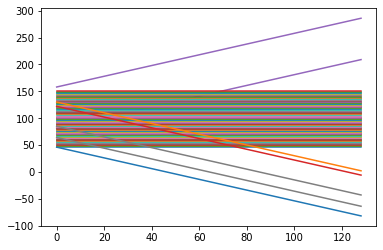

In [44]:
print(np.min(pred_mask))
print(np.max(pred_mask))
skeleton = skeletonize(rescale_intensity(tf.keras.preprocessing.image.img_to_array(pred_mask),in_range=(-1,1)))
#plt.imshow(np.squeeze(skeleton/255))

lines = []
skeleton = np.where(np.squeeze(skeleton) > 0)
#print(skeleton)
#print(skeleton[0].shape[0])
for i in range (skeleton[0].shape[0]-1):
  #print(skeleton[1][i+1])
  #print(skeleton[1][i])
  m = (skeleton[1][i+1]-skeleton[1][i])/(skeleton[0][i+1]-skeleton[0][i])
  #print("the line has a slope of : " + str(m))
  b = skeleton[0][i] + m*skeleton[1][i]
  #print("the line has its origin at : " + str(b))
  x = np.linspace(0,image.shape[0])
  if (m != 0):
    y = (1/m)*x + b
  else:
    y = b*np.ones(len(x))
  plt.plot(x,y)
  
  lines.append(y)
plt.show()
#print(lines)

# Import Tensorflow 2 and scikit-image modules.
Do not run this cell if you already imported Tensorflow 1 to use de Mask RCNN.

In [ ]:


try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import save_img

from numpy import linalg as LA

import urllib

#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import skimage
from skimage import measure
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import rotate, AffineTransform, swirl, resize
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import io, img_as_float, img_as_float64
from scipy import ndimage
from pathlib import Path

from random import random, uniform

import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow


import numba
from numba import jit


In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Utility methods for image augmentation, segmentation, cropping and proper datasets generation

In [ ]:



#measure.label()
def extract_image(img_path):
  """ method used to extract the greatest region in the mask output of the 
  Mask RCNN. 
  """
  image = skimage.io.imread(img_path, plugin='matplotlib')
  # Detect objects
  r = model.detect([image], verbose=1)[0]

  

  # Extract the greatest region 
  try:
    labels_mask = measure.label(r['masks']) 
  except ValueError:  #raised if `y` is empty.
    print('no region found.')
    return image
   
  #print(labels_mask)                 
  #print(labels_mask.astype(np.uint8))
  #plt.imshow(np.squeeze(labels_mask.astype(np.uint8)))
  #regions = measure.regionprops(np.squeeze(labels_mask.astype(np.uint8)))
  try:
    regions = measure.regionprops(labels_mask)
  except ValueError:  #raised if `y` is empty.
    print("no region found.")
    return image
  regions.sort(key=lambda x: x.area, reverse=True)
  #print(regions)
  #print(len(regions))
  #if (len(regions) == 0):
    #return image
  if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0


  labels_mask[labels_mask!=0] = 1
  mask = labels_mask
  #plt.imshow(np.squeeze(mask))

  if mask.shape[-1] > 0:
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    img_extracted = np.where(mask, image, 255).astype(np.uint8)
    image = img_extracted/255
  
  white = np.array([1, 1, 1])
  mask = np.abs(image - white).sum(axis=2) < 0.05

  # Find the bounding box of those pixels
  coords = np.array(np.nonzero(~mask))
  top_left = np.min(coords, axis=1)
  bottom_right = np.max(coords, axis=1)

  out = image[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]


  # Save output
  #file_name = "newt_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
  #skimage.io.imsave(file_name, img_extracted)
  

  return out


In [ ]:
""" Here is an example of what extract_image can do """

img_path = '/content/aug_database_for_seg/aug_database_for_seg/Bascha_P01_T01_K03_F_Adult_4307_20190320020338.jpg'
image = skimage.io.imread(img_path, plugin='matplotlib')
plt.imshow(image)
plt.show()

image_extracted = extract_image(img_path)
plt.imshow(image_extracted)
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You c

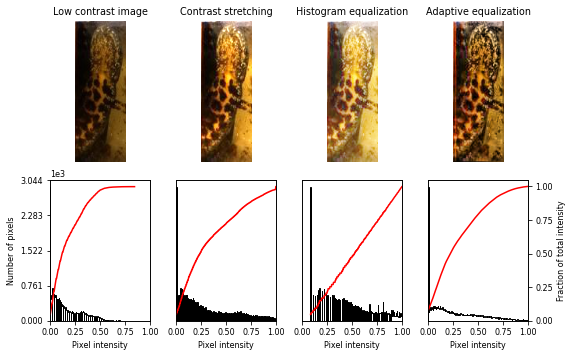

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

""" the purpose of this code is to compare different contrast enhancing methods
"""
# Load an example image
img = data.moon()
img = image
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
#img_adapteq[:,:,0] = exposure.equalize_adapthist(img[:,:,0], clip_limit=0.03)
#img_adapteq[:,:,1] = exposure.equalize_adapthist(img[:,:,1], clip_limit=0.03)
#img_adapteq[:,:,2] = exposure.equalize_adapthist(img[:,:,2], clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
def random_brightness(rgb, show_result = False):
  """ Modify randomly the brightness of the input image """
  lab = skimage.color.rgb2lab(rgb)

  #plt.imshow(lab)
  brightness = uniform(-20, 20)
  
  #print(lab[:,:,0])
  lab[:,:,0] = lab[:,:,0] + brightness
  #print(np.max(lab[:,:,0]))
  #print(lab[:,:,0])
  rgb = skimage.color.lab2rgb(lab)
  if show_result:
    plt.imshow(rgb)
    plt.show()

  return rgb

imagePath = '/content/Stage_cropped/database/Bascha_P01_T06_K20_U_Adult_8012_20190719220609.jpg'
image = img_as_float(io.imread(imagePath))
#image = image/255
image = img_adapteq
lab = random_brightness(image, show_result=True)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


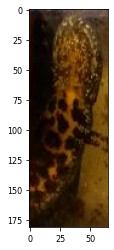

In [ ]:
def random_saturation(rgb, show_result = False):
  """ Modify randomly the saturation of the input image """
  hsv = skimage.color.rgb2hsv(rgb)

  #plt.imshow(hsv)
  saturation = uniform(-0.35, 0.35)
  
  #print(hsv[:,:,1])
  hsv[:,:,1] = hsv[:,:,1] + saturation
  #print(np.max(lab[:,:,0]))
  #print(hsv[:,:,1])
  rgb = skimage.color.hsv2rgb(hsv)

  if show_result:
    plt.imshow(rgb)
    plt.show()

  return rgb

imagePath = '/content/Stage_cropped/database/Bascha_P01_T06_K20_U_Adult_8012_20190719220609.jpg'
image = img_as_float(io.imread(imagePath))
#image = image/255
#image = img_adapteq
rgb = random_saturation(image, show_result=True)



this method was used for the segmentation algorithm, another method called augmentationImage is used to **generate a proper augmented dataset**

In [ ]:
from sklearn import preprocessing


def pre_augmentation(img_path, preAug_path):
  """ augment each image from the base dataset so that the segmentation algorithm
  have to learn more robust features, to be able to accuratly extract newts in 
  low-quality images """

  path = Path(preAug_path)

  !rm -rf /content/databaseAug

  os.makedirs(preAug_path)
  for img_name in os.listdir(img_path):
    
    imagePath = img_path + '/' + img_name

    if os.path.isfile(imagePath):

      image = img_as_float(io.imread(imagePath))
      image = exposure.equalize_adapthist(image, clip_limit=0.03)
      image = random_saturation(image, show_result=False)
      image = random_brightness(image, show_result=False)
      #print(np.max(image))
      #print(np.min(image))
      image = image*255
      #plt.imshow(image)
      #plt.show()
      
      shear = uniform(-.1, .1)
      #print(shear)
      tfr = AffineTransform(shear=shear)
      sheared = transform.warp(image, tfr, order=1, preserve_range=True,mode='constant', cval=255)
      #sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
      #plt.title('shear')
      #plt.imshow(sheared)
      #v2_imshow(sheared)
      #sheared = tf.keras.preprocessing.image.img_to_array(sheared)
      #plt.imshow(sheared)
  
      strength = uniform(-1, 1)
      #print(strength)
      image = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
      #print(image.shape)
      #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
      #print("Augmentation par couleurs")
      
      #image = tf.image.random_brightness(image, max_delta=0.10) # Random brightness
      
      
      #image = tf.image.random_contrast(image,0.5,2)
      
      #image = tf.image.random_saturation(image,0.5,2)
      #image = tf.image.random_flip_left_right(image)
      #image = tf.image.random_flip_up_down(image)
      #print(image.shape)
      augPath = preAug_path + '/' + img_name
      #print(np.max(image))
      #print(np.min(image))
      #plt.imshow(image.astype('uint8'))
      #plt.show()

      #image[:,:,0] = preprocessing.normalize(image[:,:,0])
      #image[:,:,1] = preprocessing.normalize(image[:,:,1])
      #image[:,:,2] = preprocessing.normalize(image[:,:,2])
      
      #image = tf.keras.preprocessing.image.img_to_array(image)
      #image = img_as_float(image)
      #image = image/255
      #image = tf.keras.preprocessing.image.img_to_array(image)
      #print(image)
      plt.imsave(augPath, image/255)

img_path = '/content/Stage_cropped/database'
preAug_path = '/content/databaseAug'
pre_augmentation(img_path, preAug_path)

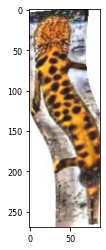

In [ ]:
""" Example of augmented image """
img_path = '/content/databaseAug/Bascha_P01_T01_K04_M_Adult_4246_20190330215714.jpg'
img = plt.imread(img_path)
plt.imshow(img)

In [ ]:
!zip -r /content/aug_database_for_seg.zip /content/databaseAug

In [ ]:
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

replace content/databaseAug/Bascha_P01_T03_K15_M_Adult_1229_20190613064950.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


new augmentation with mask rcnn output

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1855 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


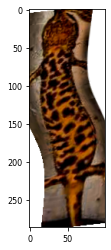

In [ ]:

def preprocess_mask_rcnn(image_path, input_shape):
  """ apply all augmentation methods defined above on the image """
  #img = skimage.io.imread(image_path, plugin='matplotlib')
  #image = img_as_float64(io.imread(image_path))
  
  #plt.imshow(image)

  #print(np.max(image))
  #image = tf.keras.preprocessing.image.img_to_array(img)

  #image = image/255
  #print(np.max(image))

  image = img_as_float(io.imread(image_path))
  image = exposure.equalize_adapthist(image, clip_limit=0.03)
  image = random_saturation(image, show_result=False)
  image = random_brightness(image, show_result=False)
     
      
  image = image*255
      #plt.imshow(image)
      #plt.show()
      
  shear = uniform(-.1, .1)
      #print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(image, tfr, order=1, preserve_range=True,mode='constant', cval=255)
      #sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
      #plt.title('shear')
      #plt.imshow(sheared)
      #v2_imshow(sheared)
      #sheared = tf.keras.preprocessing.image.img_to_array(sheared)
      #plt.imshow(sheared)
  
  strength = uniform(-1, 1)
      #print(strength)
  image = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
      #print(image.shape)

  
  #print(np.max(image))
  #print(np.min(image))
  #plt.imshow(image)
  #plt.show()
  
  #img = plt.imread(image_path)
  #img = tf.convert_to_tensor(img)
  #plt.imshow(img)
  ### Add borders around the image to have more room for wraping and swirling
 # h,w=img.shape[0:2]
  #shift = 20
  #base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  #base=np.zeros(base_size)
  #cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  #base[shift:h+shift,shift:w+shift]=img # this works
  #img = base
  #print(img)
  #cv2_imshow(img)

  #h,w=img.shape[0:2]


  #print(np.max(image))
  #image = image/255
  #print(np.max(image))
### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  
  #print(image)
  
  #plt.imshow(image)
  #plt.show()

  #white = np.array([1, 1, 1])
  #mask = np.abs(image - white).sum(axis=2) < 0.05
  
  # Find the bounding box of those pixels
  #coords = np.array(np.nonzero(~mask))
  #top_left = np.min(coords, axis=1)
  #print(top_left)
  #bottom_right = np.max(coords, axis=1)
  #print(bottom_right)

  #image = image[top_left[0]:bottom_right[0],
           #top_left[1]:bottom_right[1]]
  #print(np.max(image))
  #print(np.min(image))
  #plt.imshow(image)
  #plt.show()
  #print("Augmentation par couleurs")
  #swirled[swirled != 255]
  
  #newt = tf.image.random_brightness(newt, max_delta=0.10) # Random brightness
  #image = tf.image.random_flip_left_right(newt)
  #image = tf.image.random_flip_up_down(image)
  #image = tf.image.random_contrast(image,0.5,2)
  #image = tf.image.random_saturation(image,0.5,2)

  
    #print("height > width")
    #print("height > width")
  #plt.imshow(image/255)
  #print(image.shape)
  #plt.imshow(tf.keras.preprocessing.image.img_to_array(image))
  #print(type(image.))
  #print(image)
  

  #plt.imshow(out)
  #plt.show()
  #augPath = '/content/augDatabase/test.jpg'
  #image = image.astype(np.uint8)
  #skimage.io.imsave(augPath, image)

  return image

input_shape = (56,56,3)
img_path = '/content/Stage_cropped/database/Bascha_P01_T01_K03_F_Adult_4413_20190321004956.jpg'
img = preprocess_mask_rcnn(img_path, input_shape)
plt.imshow(img/255)


In [ ]:
input_shape = (75,30,3)


def augmentationImage(img_path,img_aug_path, input_shape):

  """ Create a proper dataset where each folder contains the images of one 
  specimen, randomly augmented 20 times for each "real" image present in the 
  original dataset """

  !rm -rf /content/databaseAug #useful when running the method again for makedirs
  data = pd.read_csv('/content/Stage_Tritons/training.csv')
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = img_path
  with os.scandir(basepath) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        #print(imagePath)
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        #img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < 20):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          image = preprocess_mask_rcnn(imagePath, input_shape)
          #image = tf.image.random_brightness(image, max_delta=0.15) # Random brightness
          #image = tf.image.random_flip_left_right(image)
          #image = tf.image.random_flip_up_down(image)
          #image = tf.image.random_contrast(image,0.5,3)
          #image = tf.image.random_saturation(image,0.5,3)
          
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          #save_img(augPath, image)
          image = tf.keras.preprocessing.image.img_to_array(image)
          #image = image*255
          #cv2.imwrite(augPath,image)
          #print(image.shape)
          #plt.imshow(image/255)
          #plt.show()
          #skimage.io.imsave(augPath,image.astype('uint8'))
          plt.imsave(augPath, image/255)
          k += 1



In [ ]:
img_path = '/content/Stage_cropped/database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path,input_shape)

Création de la base de données augmentées en cours...


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2752 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1771 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2468 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 674 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning

KeyboardInterrupt: ignored

In [ ]:
""" Train/Test split """

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..

import fnmatch



for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=10, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

40
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_2019061921094918.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T05_K16_M_Adult_11018_2019062402033513.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T05_K16_M_Adult_11018_201906240203351.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_2019061921094917.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T05_K16_M_Adult_11018_201906240203358.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_201906192109496.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_2019061921094911.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T05_K16_M_Adult_11018_2019062402033519.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_201906192109495.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_201906192109490.jpg
/content/databaseAug/train/KM00309/Bascha_P01_T03_K16_M_Adult_1924_2019061921094918.jpg
/content/databaseAug/train/KM0

In [ ]:
!zip -r /content/databaseAug.zip /content/databaseAug

In [ ]:
!unzip -q '/content/drive/My Drive/Stage/databaseAug.zip'

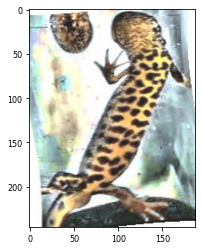

In [ ]:
""" Here is an example of an augmented image of a newt from the dataset
generated by augmentationImage """

img_path = '/content/databaseAug/test/KM00029/Bascha_P01_T02_K05_F_Adult_4675_2019031619421416.jpg'
img = plt.imread(img_path)
plt.imshow(img)

In [ ]:
def apply_mask(image, mask):
    """Apply mask on image. Pixels outside of the mask are turned white.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

In [ ]:
def extract_crop(ds_types_path, ds_final_path, input_shape):
  """ take the proper dataset created by augmentationImage and extract the newts
  by segmenting and cropping """
   
  !rm -rf /content/ds_final

  for ds_type in os.listdir(ds_types_path):
    
    print(ds_type)
    ds_path = ds_types_path + '/' + ds_type
    final_path = ds_final_path + '/' + ds_type

    

    for class_name in os.listdir(ds_path):
      
      #print(class_name)
      dsPath = ds_path + '/' + class_name
      #print(dsPath)
      dsFinalPath = final_path + '/' + class_name

      for img_name in os.listdir(dsPath):

        #if os.path.isfile(img_name):
        
          print(img_name)
          imagePath = dsPath + '/' + img_name
          augPath = dsFinalPath + '/' + img_name
          if not (os.path.isdir(dsFinalPath)):
            os.makedirs(dsFinalPath)
          
          image = extract_image(imagePath)
          #plt.imshow(image)
          #plt.show()

          height = input_shape[0]
          width = input_shape[1]
          #print(np.max(image))
          #print(np.min(image))
  
          if (image.shape[0] < image.shape[1]):
            #image = tf.image.resize(image, [width, height])
            image = resize(image, (width, height),
                       anti_aliasing=False)
            #print("height < width")
            image = np.transpose(image,(1,0,2))
          else:
            #image = tf.image.resize(image, [height, width])
            image = resize(image, (height, width),
                       anti_aliasing=False)
        
          #image = tf.keras.preprocessing.image.img_to_array(image)
         
          #plt.imshow(image)
          #plt.show()
          plt.imsave(augPath, image)

In [ ]:
input_shape = (75,30,3)
img_aug_path = '/content/databaseAug'
img_final_path = '/content/ds_final'
extract_crop(img_aug_path, img_final_path, input_shape)

test
Bascha_P01_T03_K16_M_Adult_1924_2019061921094918.jpg
Processing 1 images
image                    shape: (300, 92, 3)          min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Bascha_P01_T05_K16_M_Adult_11018_2019062402033513.jpg
Processing 1 images
image                    shape: (254, 75, 3)          min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Bascha_P01_T05_K16_M_Adult_11018_201906240203351.jpg
Processing 1 images
image      

KeyboardInterrupt: ignored

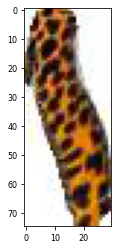

In [ ]:
""" here is an example of a pattern extracted, read from the dataset generated
by extract_crop """

img_path = '/content/ds_final/test/KM00088/Bascha_P01_T03_K15_M_Adult_1247_2019061410444712.jpg'
img = plt.imread(img_path)
plt.imshow(img)

In [ ]:
!zip -r /content/datasetFinal.zip /content/ds_final

Streaming output truncated to the last 5000 lines.
  adding: content/ds_final/test/KM00752/Bascha_P01_T04_K11_M_Adult_323_2019051803525319.jpg (deflated 9%)
  adding: content/ds_final/test/KM00752/Bascha_P01_T05_K14_M_Adult_886_201906091640359.jpg (deflated 9%)
  adding: content/ds_final/test/KM00752/Bascha_P01_T05_K14_M_Adult_886_201906091640350.jpg (deflated 10%)
  adding: content/ds_final/test/KM00752/Bascha_P01_T05_K14_M_Adult_886_201906091640352.jpg (deflated 9%)
  adding: content/ds_final/test/KM00752/Bascha_P01_T02_K13_M_Adult_806_201906021302580.jpg (deflated 9%)
  adding: content/ds_final/test/KM00609/ (stored 0%)
  adding: content/ds_final/test/KM00609/Bascha_P01_T04_K11_F_Adult_259_201905152155227.jpg (deflated 9%)
  adding: content/ds_final/test/KM00609/Bascha_P01_T01_K05_F_Adult_4589_201904031045006.jpg (deflated 9%)
  adding: content/ds_final/test/KM00609/Bascha_P01_T06_K05_F_Adult_5084_2019031605072314.jpg (deflated 9%)
  adding: content/ds_final/test/KM00609/Bascha_P01_

# Old augmentation with color segmentation, canny contours, and rectangle extraction. (do not run)
Issue : segmentation quality not consistant because of a big variability of lightness, saturation and contrast

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [ ]:
from random import random, uniform

# load Image
#img_path = '/content/database/Bascha_P01_T05_K20_U_Larva_8359_20190717223645.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1039_20190607040030.jpg'
#img_path = '/content/database/Bascha_P01_T06_K13_M_Adult_1008_20190601154259.jpg'
#img_path = '/content/database/Bascha_P01_T05_K18_M_Adult_6164_20190703234211.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
#img_path = '/content/database/Bascha_P01_T02_K13_M_Adult_750_20190531073133.jpg'

def preprocess_newts(img_path, input_shape):
  #img = imread(img_path)
  img = cv2.imread(img_path)
# plot original Image
#plt.imshow(img)
#plt.show()
#cv2_imshow(img)


  h,w=img.shape[0:2]

### Add borders around the image to have more room for wraping and swirling
  shift = 20
  base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  base=np.zeros(base_size)
  cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  base[shift:h+shift,shift:w+shift]=img # this works
  img = base
#print(img)
#cv2_imshow(img)

  h,w=img.shape[0:2]

  #print("Augmentation par déformation")

### image shearing using sklearn.transform.AffineTransform
# try out with differnt values of shear 

  shear = uniform(-.3, .3)
  #print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(img, tfr, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
#v2_imshow(sheared)

### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  strength = uniform(-1, 1)
#print(strength)
  swirled = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
#plt.imshow(swirled)
#cv2_imshow(swirled)

  img = swirled
  #print(img.shape)
  img = img.astype(np.uint8)

  img0 = cv2.equalizeHist(img[:,:,0])
  img1 = cv2.equalizeHist(img[:,:,1])
  img2 = cv2.equalizeHist(img[:,:,2])
  img[:,:,0] = img0
  img[:,:,1] = img1
  img[:,:,2] = img2


#cv2_imshow(img)

  h,w=img.shape[0:2]



  hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
  lower_yellow = np.array([5,15,25]) 
  upper_yellow = np.array([100,240,255]) 

  lower_yellow2 = np.array([160,15,25]) 
  upper_yellow2 = np.array([180,240,255]) 
#hsl(63, 20%, 81%)
  lower_black = np.array([0,0,50]) 
  upper_black = np.array([35,75,255]) 

  lower_black2 = np.array([155,0,50]) 
  upper_black2 = np.array([180,75,255]) 
# Here we are defining range of yellow color in HSL 
# This creates a mask of yellow coloured  
# objects found in the frame. 
  mask = cv2.inRange(hls, lower_yellow, upper_yellow)
  mask2 = cv2.inRange(hls, lower_yellow2, upper_yellow2)
  mask_b = cv2.inRange(hls, lower_black, upper_black) 
  mask_b2 = cv2.inRange(hls, lower_black2, upper_black2)

  mask = mask_b2+mask_b+mask+mask2
# The bitwise and of the frame and mask is done so  
# that only the blue coloured objects are highlighted  
# and stored in res 
#res = cv2.bitwise_or()
  res = cv2.bitwise_and(img,img, mask= mask) 
#cv2_imshow(img) 
#cv2_imshow(mask)
#cv2_imshow(res) 


  mask_blur = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)

  threshMap = cv2.threshold(mask_blur.astype("uint8"), 0, 255,
	  cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  kernel = np.ones((7,7),np.uint8)
  threshMap = cv2.dilate(threshMap, kernel)
  threshMap = cv2.erode(threshMap, kernel)


#cv2_imshow(mask_blur)
#cv2_imshow(threshMap)

  canny_output = auto_canny(threshMap, sigma = 0.3)
#canny_output = cv2.convertScaleAbs(canny_output)
  kernel = np.ones((9,9),np.uint8)
  threshed = cv2.dilate(canny_output,kernel)


#print(canny_output[1])
#plt.imshow(canny_output)
#plt.colorbar()
#plt.show()


## findContours(查找轮廓)
  cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

#print(cnts[0])
#plt.imshow(threshed)
#plt.colorbar()
#plt.show()
#print(cnts.shape)

#new,contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours= sorted(contours, key = cv2.contourArea, reverse = True)[:4]
#c=contours[0]
#print(cv2.contourArea(c))
#final = cv2.drawContours(img, [c], -1, (255,0, 0), 3)


#cnts = canny_output
#cnts = sorted(canny_output, key=cv2.contourArea)
## sorted by area(按照面积排序)
  cnts = sorted(cnts, key=cv2.contourArea)

## get the maximum's boundinRect(获取最大边缘的外接矩形)
  cnt = cnts[-1]

## create mask(创建掩模)
  mask = np.ones_like(threshMap, np.uint8)*cv2.GC_PR_BGD
  cv2.drawContours(mask, cnt, -1, cv2.GC_FGD, -1)

#print("shape of cnt: {}".format(cnt.shape))

#plt.imshow(mask)
#plt.colorbar()
#plt.show()

#new_image = cv2.bitwise_and(img,img,mask=mask)
#print(mask)
  new_image = threshMap.copy()
  new_image[mask == 2] = 0  # Set values not masked to be 0

#plt.imshow(new_image)
#plt.colorbar()
#plt.show()

#retval = cv2.contourArea(cnt)
#print(retval)

  rect = cv2.minAreaRect(cnt)
  #print("rect: {}".format(rect))

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  width = int(rect[1][0])
  height = int(rect[1][1])

  src_pts = box.astype("float32")
  dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(img, M, (width, height))

#cv2_imshow(warped)

  #print("Augmentation par couleurs")
  image = tf.image.random_brightness(warped, max_delta=0.10) # Random brightness
  #image = tf.image.random_flip_left_right(image)
  #image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image,0.5,2)
  image = tf.image.random_saturation(image,0.5,2)

  height = input_shape[0]
  width = input_shape[1]
  
  if (image.shape[0] < image.shape[1]):
    image = tf.image.resize(image, [width, height])
    #print("height < width")
    image = tf.image.transpose(image)
  else:
    image = tf.image.resize(image, [height, width])
    #print("height > width")

  return image

#from keras.preprocessing.image import array_to_img, img_to_array
#img = img_to_array(image)
#cv2_imshow(img.astype('uint8'))



In [ ]:
input_shape = (56,56,3)


def augmentationImage(img_path,img_aug_path, input_shape):

  
  !rm -rf /content/content/databaseAug
  data = pd.read_csv('/content/content/Stage/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = '/content/content/Stage/database'
  with os.scandir(basepath) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        #img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < 20):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          #image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
          #image = tf.image.random_flip_left_right(image)
          #image = tf.image.random_flip_up_down(image)
          #image = tf.image.random_contrast(image,0.5,3)
          #image = tf.image.random_saturation(image,0.5,3)
          image = preprocess_newts(imagePath, input_shape)
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          #save_img(augPath, image)
          image = tf.keras.preprocessing.image.img_to_array(image)
          #print(image.shape)
          cv2.imwrite(augPath,image*255)
          #plt.imsave(augPath, image/255)
          k += 1



In [ ]:
img_path = '/content/Stage_cropped/database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path,input_shape)

# Import the augmented, cropped dataset to begin the training with the triplet loss embedding

In [ ]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/test'))
print(test_size)

In [ ]:


#width = 56
#height = 56

train_path = '/content/ds_final/train'
test_path = '/content/ds_final/test'

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-2])
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  #img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  try:
    img = decode_img(img)
    #print(np.max(img))
    print("decoded")
    counter +=1
  except:
    print("erreur décodage")

  return img, label

def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (input_shape[0], input_shape[1]))
  return image, label

In [ ]:
train_path = '/content/ds_final/train'
test_path = '/content/ds_final/test'

train_size = sum(len(files) for _, _, files in os.walk(train_path))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(test_path))
print(test_size)

#BATCH_SIZE = 32
#input_shape = (50,35,3)
#data_dir = "/content/male"
input_shape = (75,32,3)



data_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')
list_ds_test = tf.data.Dataset.list_files(str(test_dir)+'/*/*')

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
#print(type(CLASS_NAMES))
print(CLASS_NAMES)
#for f in list_ds.take(5):
  #print(f.numpy())
#counter = 0

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  #image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

#train_size = int(0.7 * nbr_element)

#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)


#full_dataset = labeled_ds.shuffle()
#train_dataset = labeled_ds.take(train_size)
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)

train_dataset = labeled_ds.map(format_image, num_parallel_calls=AUTOTUNE)
test_dataset = labeled_ds_test.map(format_image, num_parallel_calls=AUTOTUNE)

count_label = len(os.listdir(train_path))
#print(count_label)

x_train = np.zeros((train_size,input_shape[0],input_shape[1],input_shape[2]))
y_train = np.zeros((train_size))
x_test = np.zeros((test_size,input_shape[0],input_shape[1],input_shape[2]))
y_test = np.zeros((test_size))

k=0
for image, label in train_dataset:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1
k=0
for image, label in test_dataset:
  x_test[k,:,:,:] = image
  y_test[k] = np.where(label)[0][0]
  k += 1
  #print(np.where(label)[0])

#tfds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#tfds_train = tfds_train.batch(32)
#for i,j in tfds_train:
 # print(i)
  #print(j)
#tfds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#tfds_test = tfds_test.batch(32)
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
#print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(count_label):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train)


    images_class_n_test = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    dataset_test.append(images_class_n_test)

  
print("nombre de classes différentes : "+ str(count_label))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
#input_shape = [width,height,3]




16870
5570
['KM00579' 'KM00176' 'KM00993' 'KM00230' 'KM00721' 'KM00695' 'KM00425'
 'KM00703' 'KM00890' 'KM00957' 'KM00540' 'KM00927' 'KM00105' 'KM00992'
 'KM00186' 'KM00571' 'KM00893' 'KM00973' 'KM00002' 'KM00934' 'KM00014'
 'KM00536' 'KM00850' 'KM00401' 'KM00869' 'KM00557' 'KM00863' 'KM00621'
 'KM00095' 'KM00498' 'KM00336' 'KM00683' 'KM00752' 'KM00609' 'KM00222'
 'KM00101' 'KM00361' 'KM00012' 'KM00106' 'KM00816' 'KM00937' 'KM00402'
 'KM00926' 'KM00733' 'KM00787' 'KM00896' 'KM00881' 'KM00954' 'KM00915'
 'KM00099' 'KM00979' 'KM00132' 'KM00093' 'KM00898' 'KM00587' 'KM00725'
 'KM00676' 'KM00749' 'KM00241' 'KM00991' 'KM00510' 'KM00035' 'KM00270'
 'KM00072' 'KM00627' 'KM00758' 'KM00470' 'KM00152' 'KM00407' 'KM00244'
 'KM00798' 'KM00473' 'KM00116' 'KM00315' 'KM00178' 'KM00440' 'KM00568'
 'KM00906' 'KM00560' 'KM00804' 'KM00975' 'KM00544' 'KM00309' 'KM00849'
 'KM00308' 'KM00158' 'KM00314' 'KM00534' 'KM00343' 'KM00485' 'KM00941'
 'KM00089' 'KM00885' 'KM00460' 'KM00868' 'KM00034' 'KM00705' 'KM00

In [ ]:
np.max(dataset[0])

1.0

In [ ]:
!zip -r /content/augmentedNewts56.zip /content/content/databaseAug
#from google.colab import files
#files.download("/content/Stage_Dataset.zip")

# Only to compare the performances, import the AmphIdent outputs dataset. (do not run)



In [ ]:
width = 32
height = 75


def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #for part in parts:
   # print(part)
  #lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  #lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES
  #assert not id.empty 
  #print(id.index)

 # id = ids.iloc[id.index]
  #print(id)
  # The second to last is the class-directory
  #print(type(tf.convert_to_tensor(id)))
  #return tf.convert_to_tensor(id)[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [width, height])

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

In [ ]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/test'))
print(test_size)

In [ ]:
#BATCH_SIZE = 32

#data_dir = "/content/male"

#base_path = "/content/Stage/database"


#nathan_ds = tf.data.Dataset.list_files(str(nathan_dir)+'/*')

#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

#for f in list_ds.take(5):
  #print(f.numpy())
#counter = 0


ds_path = "/content/dataset_amphident/dataset_amphident"
ds_path = pathlib.Path(ds_path)

ds_dir = os.listdir(ds_path)

CLASS_NAMES = []

for pattern in ds_dir:
  i = 0
  while (pattern[i] != "_"):
    i += 1
  CLASS_NAMES.append(pattern[:i])
  #print(pattern[:i])

CLASS_NAMES = np.array(CLASS_NAMES)
CLASS_NAMES = np.unique(CLASS_NAMES)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:
#nathands = tf.data.Dataset.list_files(str(nathan_ds)+'/*')
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
#labeled_ds = ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.bool]), num_parallel_calls = AUTOTUNE)
#print(labeled_ds_nathan)
#for image,label in labeled_ds:
  #print(image)
  #print(label)
#labeled_ds_remy = remy_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#train_size = int(0.7 * nbr_element)
#train_size=nbr_element-count_label*4
#test_size=count_label*4
#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)
#print(patterns)
train_size = patterns.size

#full_dataset = labeled_ds.shuffle()
#train_dataset = labeled_ds_nathan.take(len(nathan_ds))
#train_dataset2 = labeled_ds_remy.take(len(remy_ds))
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)
train_dataset = ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.bool]), num_parallel_calls = AUTOTUNE)
#train_dataset2 = labeled_ds_remy.map(augment, num_parallel_calls=AUTOTUNE)
test_dataset = ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.bool]), num_parallel_calls = AUTOTUNE)

x_train = np.zeros((train_size,width,height,3))
y_train = np.zeros((train_size,1))
x_test = np.zeros((test_size,width,height,3))
y_test = np.zeros((test_size))

k=0
for image,label in train_dataset:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1

k=0
for image, label in test_dataset:
 x_test[k,:,:,:] = image
 y_test[k] = np.where(label)[0][0]
 k += 1
 print(np.where(label)[0])


print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(len(labels)):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train/255)

    images_class_n_test = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    dataset_test.append(images_class_n_test/255)

  
print("nombre de classes différentes : "+ str(count_label))
  
input_shape = [width,height,3]




[[481.]
 [715.]
 [380.]
 ...
 [226.]
 [476.]
 [451.]]


MNIST dataset that was used at the very beginning of the project, (do not run)

In [ ]:
""" build MNIST dataset """

nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """

    #fashion_mnist = tf.keras.datasets.fashion_mnist

    #(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = fashion_mnist.load_data()
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = datasets.mnist.load_data()

    assert backend.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        #print(images_class_n.shape)
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
    
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

dataset,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()

11493376/11490434 [==============================] - 0s 0us/step


# Triplet Loss Embedding implementation

![fig2](https://user-images.githubusercontent.com/18154355/61485417-1cbb1f00-a96f-11e9-8d6a-94964ce8c4db.png)

## Build different architectures of neural networks

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network_feedforward(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Flatten(input_shape=input_shape))
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network



In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(500, (9,9), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [ ]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network

This neural network is the best, do not run the others

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(512, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(512, (5,5), activation='relu', kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(512, (3,3), activation='relu', kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    #network.add(Dropout(0.5))
    
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    network.add(BatchNormalization())
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (5,5),
                     input_shape=input_shape,
                     kernel_initializer='he_uniform'))
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
                     ##kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    
    network.add(Flatten())
    network.add(Dense(2048,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(512,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network


##Triplet Loss

As first introduced in the FaceNet paper, TripletLoss is a loss function that trains a neural network to closely embed features of the same class while maximizing the distance between embeddings of different classes.  To do this an anchor  is chosen along with one negative and one positive sample.
![fig3](https://user-images.githubusercontent.com/18154355/61485418-1cbb1f00-a96f-11e9-8de8-3c46eef5a7dc.png)




## Handle the batching of images as in the paper

In [ ]:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c), (batch_size,w,h,c,k), (batch_size,w,h,c,k,p)
    """
    
    
    m, w, h, c = dataset[0].shape
   # print(m)
    P = int(batch_size*3/4)
    K = 4

    k = 0
    # initialize result
    anchors =np.zeros((P*K, w, h, c))
    positives = np.zeros((P*K, w, h, c, K))
    negatives = np.zeros((P*K, w, h, c, K, P))
    #negatives = np.zeros((P*K, P, K, h, w, c))
    #print("PK =  " + str(P*K))
    
    #Pick one random class for anchor
    #print("nombre de classes : " + str(count_label))
    anchor_class = np.random.choice(count_label, size=P, replace=False)
    #print("longueur anchoir_class : "+str(len(anchor_class)))
    for i in range(len(anchor_class)):

      anchor = anchor_class[i]
     # print(anchor)
      nb_sample_available_for_class_A = dataset[anchor].shape[0]
      
      #Pick K different random pics for this class => A and P
      idxAP = np.random.choice(nb_sample_available_for_class_A,size=K+1,replace=False)
      #print("longueur idxAp : "+str(len(idxAP)))


      negative_class = [id for id in anchor_class if id != anchor]

      for j in range(K):
        idA = idxAP[j]
        idPx = [id for id in idxAP if id != idA]
        #print(i*K+j)
        #print("valeur de i : " + str(i))
        #print("valeur de j : " + str(j))
        #print("longueur idPx " + str(len(idPx)))
        anchors[i*K+j,:,:,:] = dataset[anchor][idA,:,:,:]
        
        for k in range(len(idPx)):
          idP = idPx[k]
          #print(idP)
          positives[i*K+j,:,:,:,k] = dataset[anchor][idP,:,:,:]

        for l in range(len(negative_class)):
            negative = negative_class[l]
            nb_sample_available_for_class_N = dataset[negative].shape[0]
            idxN = np.random.choice(nb_sample_available_for_class_N,size=K,replace=False)

            for k in range(len(idxN)):
              idN = idxN[k]
              negatives[i*K+j,:,:,:,k,l] = dataset[negative][idN,:,:,:]
          
         # if(k>0):
         #   print(positives[i*K+j,:,:,:,k]-positives[i*K+j,:,:,:,k-1])
        
        

        #Pick K different random pics for this class => N
          

        #print("i : " + str(i))
        #print("l : " + str(l))
        #print(i*K+l)

        #
        
          
            #if(k>0):
             # print(tf.subtract(negatives[i*K+l,:,:,:,k,j],negatives[i*K+l,:,:,:,k-1,j]))
        
        #Pick a random pic for this negative class => N
    #print("affichage positives batch random moderate")
    #plt.figure()
    #plt.imshow(positives[0,:,:,0,3])

    

    return anchors, positives, negatives

tripletbatch = get_batch_moderate_random(batch_size=8, dataset = dataset)



/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'dataset' of function 'get_batch_moderate_random'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-54689f697f20>", line 2:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'dataset' of function 'get_batch_moderate_random'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-54689f697f20>", line 2:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

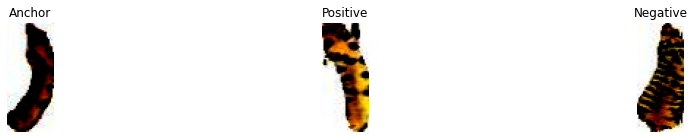

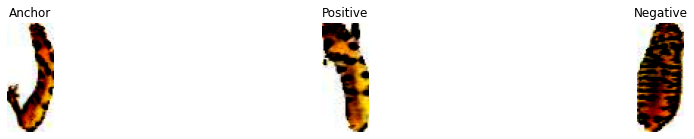

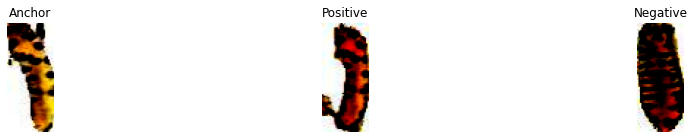

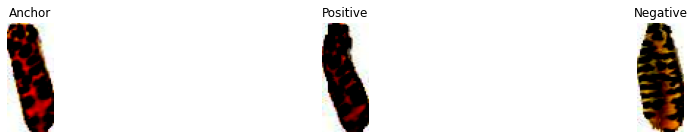

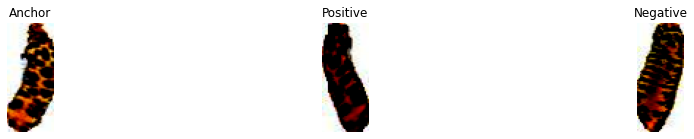

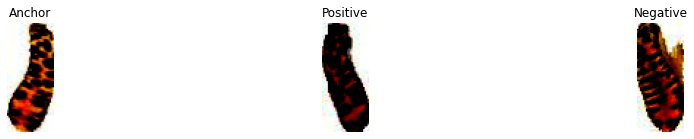

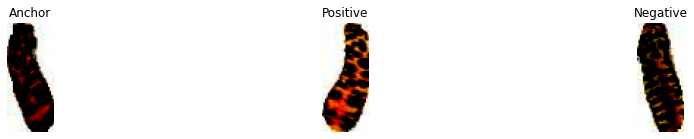

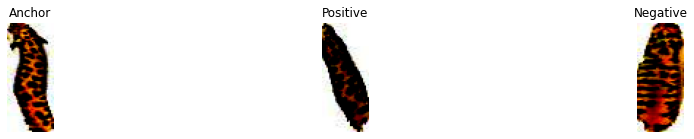

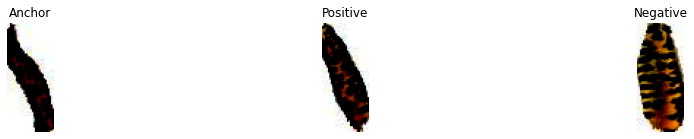

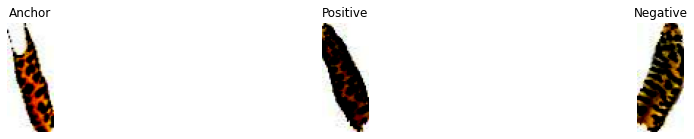

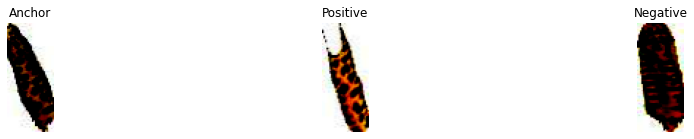

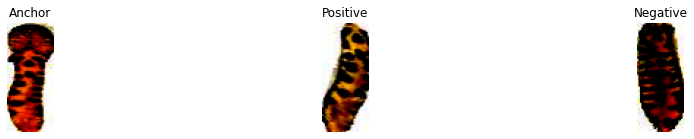

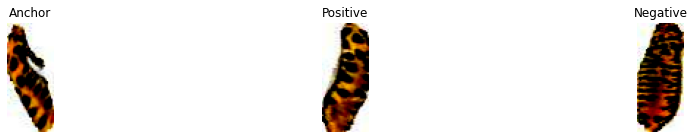

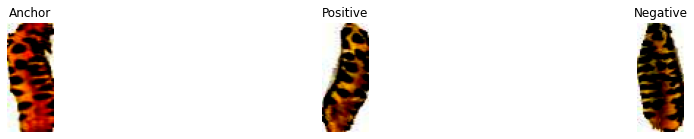

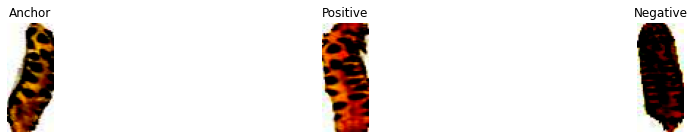

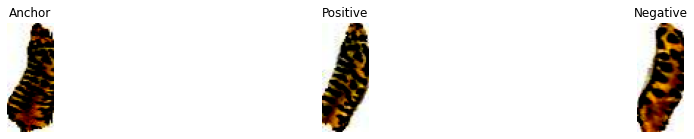

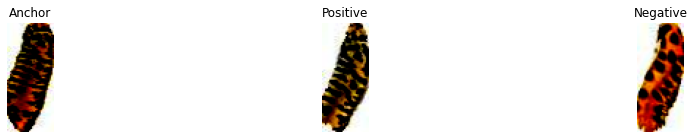

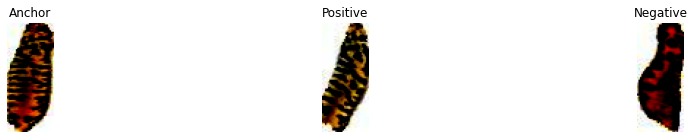

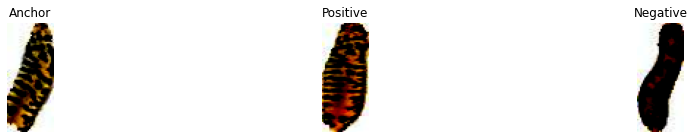

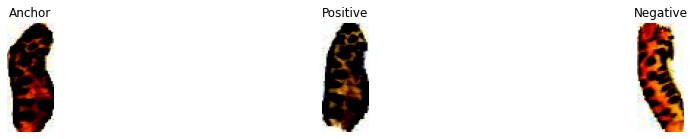

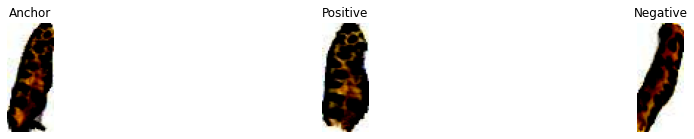

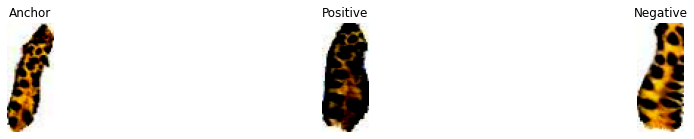

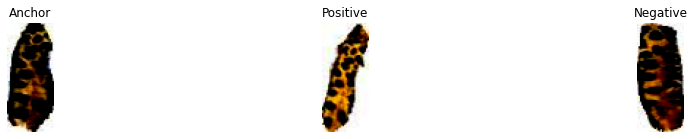

In [ ]:


model = build_network(input_shape,256)


def get_batch_moderate(batch_size,network,dataset,s="train"):
    """
    Create batch of APN "moderate" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_moderate_random(batch_size,dataset,s)
    
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    #print(A.shape)
    P = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4]))
    N = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))  


    for i in range(studybatch[1].shape[4]):
      P[:,:,i] = network.predict(studybatch[1][:,:,:,:,i])
     # plt.figure()
     # plt.imshow(np.squeeze(studybatch[1][0,:,:,:,i]))
      #print(studybatch[1][:,:,:,:,i])
      #if(i>0):
       # print("Pi - Pi-1")
        #print(P[:,:,i] - P[:,:,i-1])
      for j in range(studybatch[2].shape[5]):
        N[:,:,i,j] = network.predict(studybatch[2][:,:,:,:,i,j])
        #if(i>0):
         # print("Ni,j - Ni-1,j")
          #print(N[:,:,i,j] - N[:,:,i-1,j])

    
    ### Extraction des indices des distances maximales
    
    A = tf.expand_dims(A, axis = -1)
    #print(A)
    #print(P)
    dist_p = tf.math.subtract(A,P)
    #print(dist_p)
    dist_p = tf.norm(tf.math.subtract(A,P),axis = -2)
    #print(dist_p)
    selectionAP = tf.math.argmax(tf.norm(A - P,axis = -2), axis = -1)
    #print(selectionAP)
   # print(selectionAP.shape)
    #dist_p = tf.dtypes.cast(dist_p, tf.double)

    
    sub = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))    
    for i in range(N.shape[3]):
      #print(A.shape)
      #print(tf.math.subtract(N[:,:,i+1,i],N[:,:,i,i]))
      sub[:,:,:,i] = tf.math.subtract(A,N[:,:,:,i])
      #print(sub[:,:,:,i])
    #A = tf.expand_dims(A, axis = -1)
    #print(sub)
    n_dist = tf.norm(sub,axis = 1)
    #print(n_dist)
    n_dist = tf.reduce_min(n_dist, axis = -2)
    #print("n_dist")
    #print(n_dist)
    selectionN = np.argmin(n_dist, axis = -1)
    #print("selectionN")
    #print(selectionN)
   # print(selectionN.shape)
    AN = tf.norm(sub,axis = -3)
    #print("AN")
    #print(AN)

    selectionPN = np.zeros((AN.shape[0]),dtype=np.int8)
    for i in range(AN.shape[0]):
      #print(AN[i,:,selectionN[i]])
      selectionPN[i] = np.argmin(AN[i,:,selectionN[i]])
      
      #print(selectionPN[i])
   # print("selectionPN")
    #print(selectionPN)
    #n_dist = tf.dtypes.cast(n_dist, tf.double)
    batch_size = studybatch[2][:,0,0,0,0,0].shape[0]
   # print(batch_size)
    width = studybatch[2][0,:,0,0,0,0].shape[0]
   # print(width)
    height = studybatch[2][0,0,:,0,0,0].shape[0]
   # print(height)
    channels = studybatch[2][0,0,0,:,0,0].shape[0]
   # print(channels)
    K = studybatch[2][0,0,0,0,:,0].shape[0]
   # print(K)
    N = studybatch[2][0,0,0,0,0,:].shape[0]
   # print(N)

    ### Création des tenseurs contenant les images sélectionnées de telles sortes à maximiser les distances AP et à minimiser les distances AN
    positives = tf.zeros((batch_size,width,height,channels))
    negatives = tf.zeros((batch_size,width,height,channels))

    #print(selectionPN)
    #print(selectionN)
    
    #print(P.shape)
    #print(N.shape)

    
    for i in range(studybatch[2][:,0,0,0,0,0].shape[0]):
      positives = studybatch[1][:,:,:,:,selectionAP[i]]
      #positives = np.squeeze(positives)
      #print(positives)
      #print(positives.shape)
      negatives = studybatch[2][:,:,:,:,selectionPN[i],selectionN[i]]
      #negatives = np.squeeze(negatives)
      #print(negatives.shape)

    #print(positives[0,:,:,0])
    #print(negatives[0,:,:,0])
    #print(positives[0,:,:,:])
    #print(negatives[0,:,:,:])
    #plt.figure()
    #plt.imshow(positives[0,:,:,0])
    #plt.figure()
    #plt.imshow(negatives[0,:,:,0])

    #studybatchloss = tf.math.reduce_sum(tf.math.log1p(tf.math.subtract(p_dist,n_dist)))
    #studybatchloss = tf.dtypes.cast(studybatchloss, tf.float32)

    triplets = [studybatch[0][:,:,:,:], positives, negatives]

    #print(NMin.shape)

    #Compute d(A,P)-d(A,N)
    #studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the inverse
    #selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    #selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    #selection = np.append(selection,selection2)
    
    #triplets = [A,P,N]
    #print(triplets.shape)
    return triplets

tripletbatch = get_batch_moderate(8, model, dataset)
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.axis("off")
            triplet = tripletbatch[i][row,:,:,:]

            plt.imshow(triplet)
            subplot.title.set_text(labels[i])

drawTriplets(tripletbatch=tripletbatch)



## Triplet loss layer computing the formula introduced in the paper

**the Euclidean distance is used**

In [ ]:

class TripletLossLayerModerate(layers.Layer):
    def __init__(self, **kwargs):
        #self.alpha = alpha
        super(TripletLossLayerModerate, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        A, P, N = inputs
        
        p_dist = tf.norm(A - P,axis = -1)
        n_dist = tf.norm(A - N,axis = -1)
        
        #tripletLoss = tf.math.reduce_sum(tf.math.add(self.alpha,tf.math.subtract(p_dist,n_dist)))

        #Utilisation de la formule de batch_hard du papier avec marge douce
        tripletLoss = tf.math.reduce_sum(tf.math.log1p(tf.math.exp(tf.math.subtract(p_dist,n_dist))))
        tripletLoss = tf.dtypes.cast(tripletLoss, tf.float32)
        #tripletLoss = backend.sum(backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        return(tripletLoss)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss



## Concatenate three instances of the same neural network representing the anchors, the positives and the negatives necessary for the triplet loss embedding algorithm

In [ ]:
def build_model_moderate(input_shape, network, margin = 0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
    
    
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    #loss_layer = TripletLossLayerModerate(alpha = margin, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    loss_layer = TripletLossLayerModerate(name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train



## Define metrics to evaluate the performances of the neural networks

In [ ]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
#count_label = len(dataset)

def mean_average_precision(X,Y,network,rank):
    '''
    Returns
        MAP : the mean of the average precision of the model for each images of the dataset
    '''
    nb_classes = count_label
    print(nb_classes)
    m = X.shape[0]
    #nbtrain = 10
    nbevaluation = 10
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:,:,:,:]
          #print(selected_ref.shape)
          #print(np.max(selected_ref))
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              #print(np.max(ref_images[k,:]))
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:], axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    AP = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      print(ytrue)
      print(ypreds[i,0])
      for k in range(rank):
        
        if(ytrue[i] == ypreds[i,k]):
          AP += 1/(k+1)
    
    MAP = AP/len(ytrue)
    print(MAP)
    return MAP

def cumulative_matching_curve(X,Y,network,rank):
  
    '''
    Returns
        CMC : 
    '''
    nb_classes = count_label
    m = X.shape[0]
    nbtrain = 1000
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:nbtrain,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    present = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      for k in range(rank):
        #print(ytrue)
        #print(ypreds[i,k])
        if(ytrue[i] == ypreds[i,k]):
          present += 1
    
    CMC = present/len(ytrue)
    print(CMC)
    return CMC

    


def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    nb_classes = count_label
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,28,28,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

# Training the network

## Transfer learning

### Use the ResNet50 architecture

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
feature = base_model(tf.expand_dims(image, 0))
print(feature.shape)

(1, 3, 1, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_averaged = global_average_layer(feature)
print(feature_averaged.shape)

embedding_layer = tf.keras.layers.Dense(512)
normalization = tf.keras.layers.BatchNormalization()
relu = tf.keras.layers.ReLU()
embedding = embedding_layer(feature_averaged)
print(embedding.shape)

embedding_layer2 = tf.keras.layers.Dense(64)
embedding2 = embedding_layer2(embedding)
print(embedding2.shape)

(1, 2048)
(1, 512)
(1, 64)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  embedding_layer,
  normalization,
  relu,
  embedding_layer2
])

### Train the model

In [ ]:
import time
#embedding_size = 256
tf.keras.backend.clear_session()
#model = build_network(input_shape,embedding_size)
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

n_iter = 3000
t_stop = 0
iter_stop = 0
#inter_dist = compute_interdist(model)
#print(inter_dist)

In [ ]:


#model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False))


if (iter_stop != 0):
  n_iteration = iter_stop
else:
  n_iteration = 0

evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

if (t_stop != 0):
  t_start = t_stop

distribution = np.zeros((10,3))

plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(50,model,dataset)
    #triplets = get_batch_hard(32,16,16,model)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    t_stop = time.time()
    iter_stop = n_iteration

    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))
        
       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 3.3 mins, Train Loss: 79.97442626953125

 ------------- 

[20] Time for 20 iterations: 6.3 mins, Train Loss: 119.83399963378906

 ------------- 

[30] Time for 30 iterations: 9.4 mins, Train Loss: 104.28145599365234

 ------------- 

[40] Time for 40 iterations: 12.4 mins, Train Loss: 23.851720809936523

 ------------- 

[50] Time for 50 iterations: 15.4 mins, Train Loss: 42.923641204833984

 ------------- 

[60] Time for 60 iterations: 18.4 mins, Train Loss: 51.95146942138672

 ------------- 

[70] Time for 70 iterations: 21.5 mins, Train Loss: 141.24868774414062

 ------------- 

[80] Time for 80 iterations: 24.5 mins, Train Loss: 37.08208084106445

 ------------- 

[90] Time for 90 iterations: 27.5 mins, Train Loss: 159.09640502929688

 ------------- 

[100] Time for 100 iterations: 30.6 mins, Train Loss: 155.79490661621094

 ------------- 

[110] Time for 110 iterations: 

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

### Fine-tune after training

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


### Continue to train the network 

In [ ]:


#model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False))


if (iter_stop != 0):
  n_iteration = iter_stop
else:
  n_iteration = 0

evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

if (t_stop != 0):
  t_start = t_stop

distribution = np.zeros((10,3))

plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(50,model,dataset)
    #triplets = get_batch_hard(32,16,16,model)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    t_stop = time.time()
    iter_stop = n_iteration

    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))
        
       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 3.3 mins, Train Loss: 79.97442626953125

 ------------- 

[20] Time for 20 iterations: 6.3 mins, Train Loss: 119.83399963378906

 ------------- 

[30] Time for 30 iterations: 9.4 mins, Train Loss: 104.28145599365234

 ------------- 

[40] Time for 40 iterations: 12.4 mins, Train Loss: 23.851720809936523

 ------------- 

[50] Time for 50 iterations: 15.4 mins, Train Loss: 42.923641204833984

 ------------- 

[60] Time for 60 iterations: 18.4 mins, Train Loss: 51.95146942138672

 ------------- 

[70] Time for 70 iterations: 21.5 mins, Train Loss: 141.24868774414062

 ------------- 

[80] Time for 80 iterations: 24.5 mins, Train Loss: 37.08208084106445

 ------------- 

[90] Time for 90 iterations: 27.5 mins, Train Loss: 159.09640502929688

 ------------- 

[100] Time for 100 iterations: 30.6 mins, Train Loss: 155.79490661621094

 ------------- 

[110] Time for 110 iterations: 

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

## Training from scratch with a 3-layered CNN

### Define the architecture and train the model

In [ ]:
import time
embedding_size = 256
tf.keras.backend.clear_session()
model = build_network(input_shape,embedding_size)
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

n_iter = 3000
t_stop = 0
iter_stop = 0
#inter_dist = compute_interdist(model)
#print(inter_dist)

In [ ]:


#model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False))


if (iter_stop != 0):
  n_iteration = iter_stop
else:
  n_iteration = 0

evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

if (t_stop != 0):
  t_start = t_stop

distribution = np.zeros((10,3))

plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(14,model,dataset)
    #triplets = get_batch_hard(32,16,16,model)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    t_stop = time.time()
    iter_stop = n_iteration

    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))
        
       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 3.3 mins, Train Loss: 79.97442626953125

 ------------- 

[20] Time for 20 iterations: 6.3 mins, Train Loss: 119.83399963378906

 ------------- 

[30] Time for 30 iterations: 9.4 mins, Train Loss: 104.28145599365234

 ------------- 

[40] Time for 40 iterations: 12.4 mins, Train Loss: 23.851720809936523

 ------------- 

[50] Time for 50 iterations: 15.4 mins, Train Loss: 42.923641204833984

 ------------- 

[60] Time for 60 iterations: 18.4 mins, Train Loss: 51.95146942138672

 ------------- 

[70] Time for 70 iterations: 21.5 mins, Train Loss: 141.24868774414062

 ------------- 

[80] Time for 80 iterations: 24.5 mins, Train Loss: 37.08208084106445

 ------------- 

[90] Time for 90 iterations: 27.5 mins, Train Loss: 159.09640502929688

 ------------- 

[100] Time for 100 iterations: 30.6 mins, Train Loss: 155.79490661621094

 ------------- 

[110] Time for 110 iterations: 

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

# Evaluate the model with the two metrics used in the paper : 

## Mean Average Precision

In [ ]:
#print(dataset_train)
MAP = mean_average_precision(x_test,y_test,model,1)

557
0.255530117049789
0
1
2
3
4
5
6
7
8
9
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
421
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
218
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
242
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
385
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
318
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
304
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
17
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
289
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
80
[  0.  55. 110. 374. 524. 267. 229. 289. 532. 103.]
289
0.1


## Cumulative Matching Characteristc

In [ ]:
CMC = cumulative_matching_curve(x_test,y_test,model,3)